# Tic-Tac Toe Training Algorithms
Assignment for Deep Learning Computer Vision course

In [1]:
!python -m venv tic_tac_toe_env
!source tic_tac_toe_env/bin/activate

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import metrics
from sklearn.neural_network import MLPClassifier, MLPRegressor

import seaborn as sn

import pandas as pd

import os

import pickle 

import numpy as np

## Import code from notebook that contains predictions functions and linear class

In [3]:
%run PredictFuncs.ipynb

## Define variables
- **data** contains the datasets
- **file_dir** is the directory of the datasets
- **file_names** is a list of dicts containing the filename, a shorthand reference, and the type of data (classification or regression)

In [4]:
# Define file directory and file names
data = {}
file_dir = 'datasets-part1/datasets-part1/'
filenames = [
    {
        'name': 'tictac_single.txt',
        'ref': 'single',
        'type': 'classification'
    },
    {
        'name': 'tictac_multi.txt',
        'ref': 'multi',
        'type': 'regression'
    },
    {
        'name': 'tictac_final.txt',
        'ref': 'final',
        'type': 'classification'
    }
]

## Load datasets
- **examples** is a list. Each entry is a list of the features.
- **labels** is a list. Each entry is a list of the labels.

In [5]:
# Load datasets
for filename in filenames:
    file = np.loadtxt('{}{}'.format(file_dir, filename['name']))
    file_data = {}
    file_type = filename['type']
    
    if file_type == 'classification':
        file_data = {
            'examples': file[:, :file.shape[1] - 1],
            'labels': file[:, file.shape[1] - 1]
        }
    elif file_type == 'regression':
        file_data = {
            'examples': file[:, :int(file.shape[1] / 2)],
            'labels': file[:, int(file.shape[1] / 2):]
        }
        
    data[filename['ref']] = file_data


## Change the -1 to a 0 in the **tictac_final.txt** data
- This is to prevent a cross validation averaging error to return a 0 when the only allowable values are -1 and 1

In [6]:
data['final']['labels'][data['final']['labels'] == -1] = 0

## Data Visualization

/scratch/local/9821620/ipykernel_114177/1106928928.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


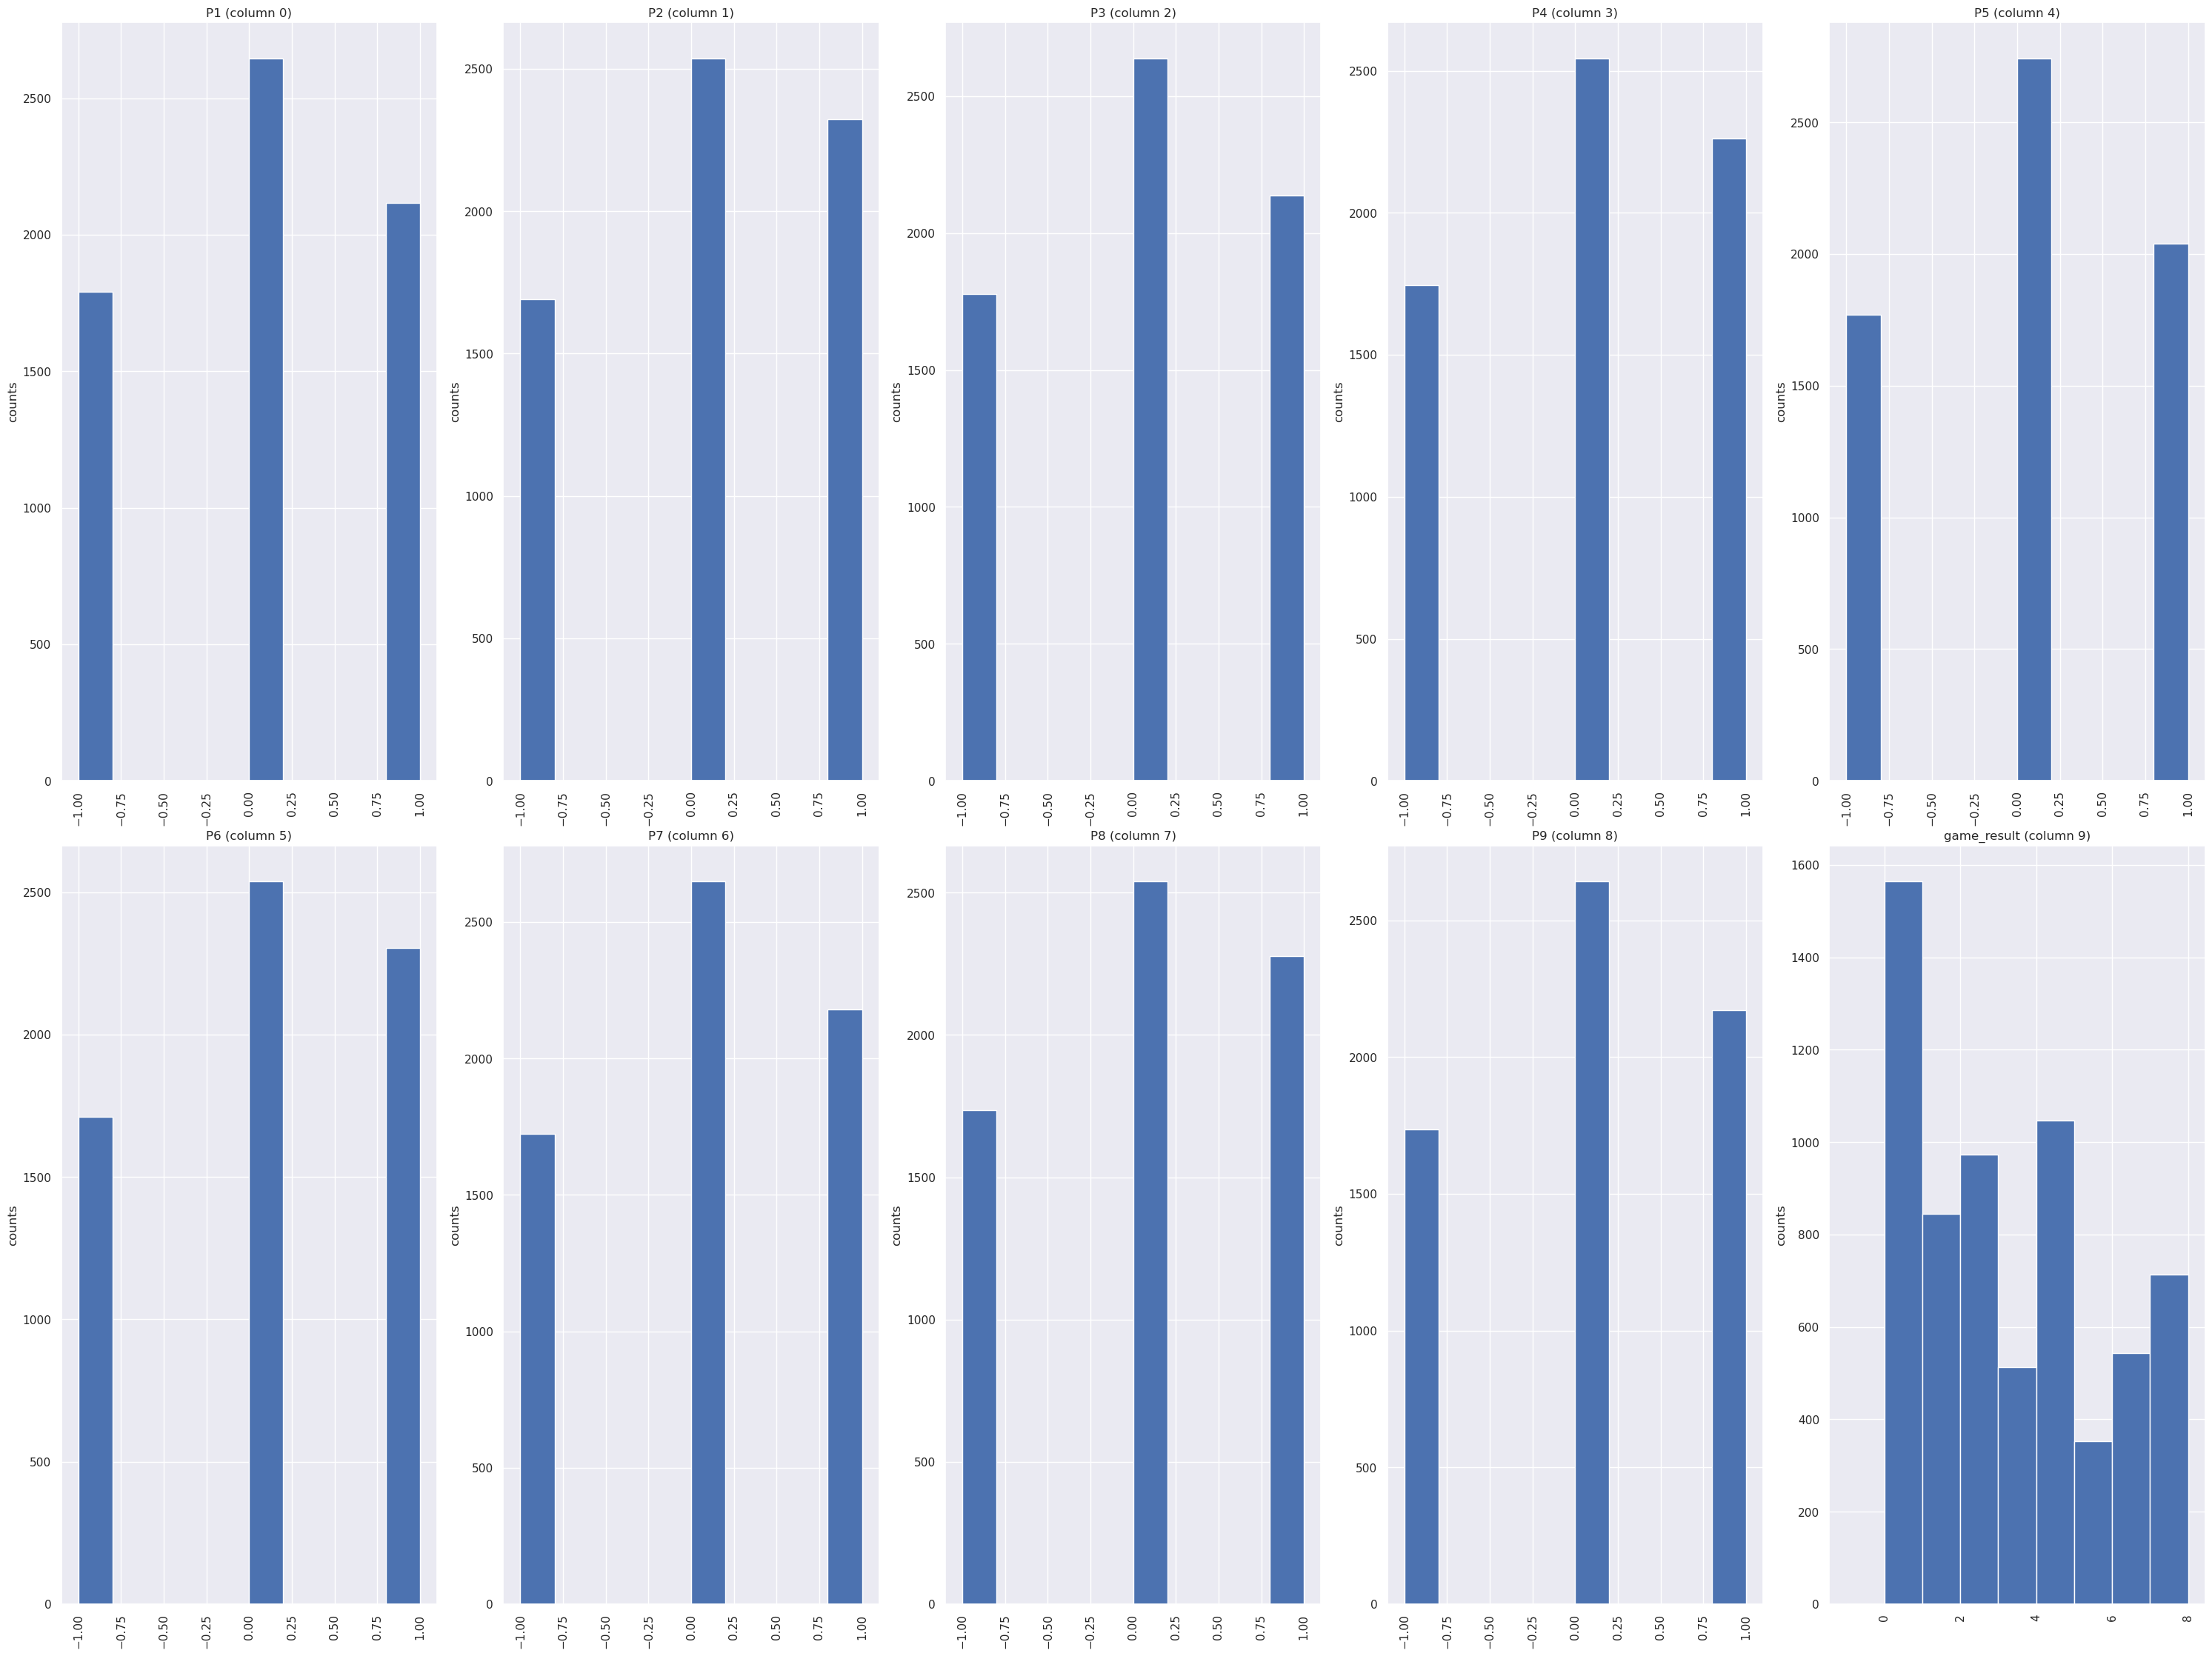

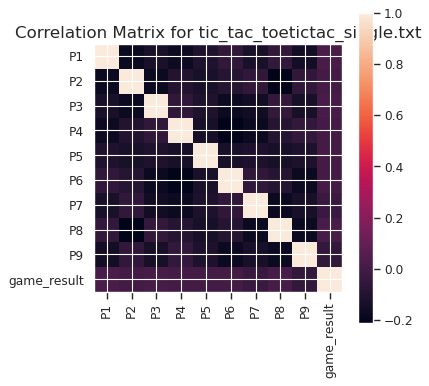

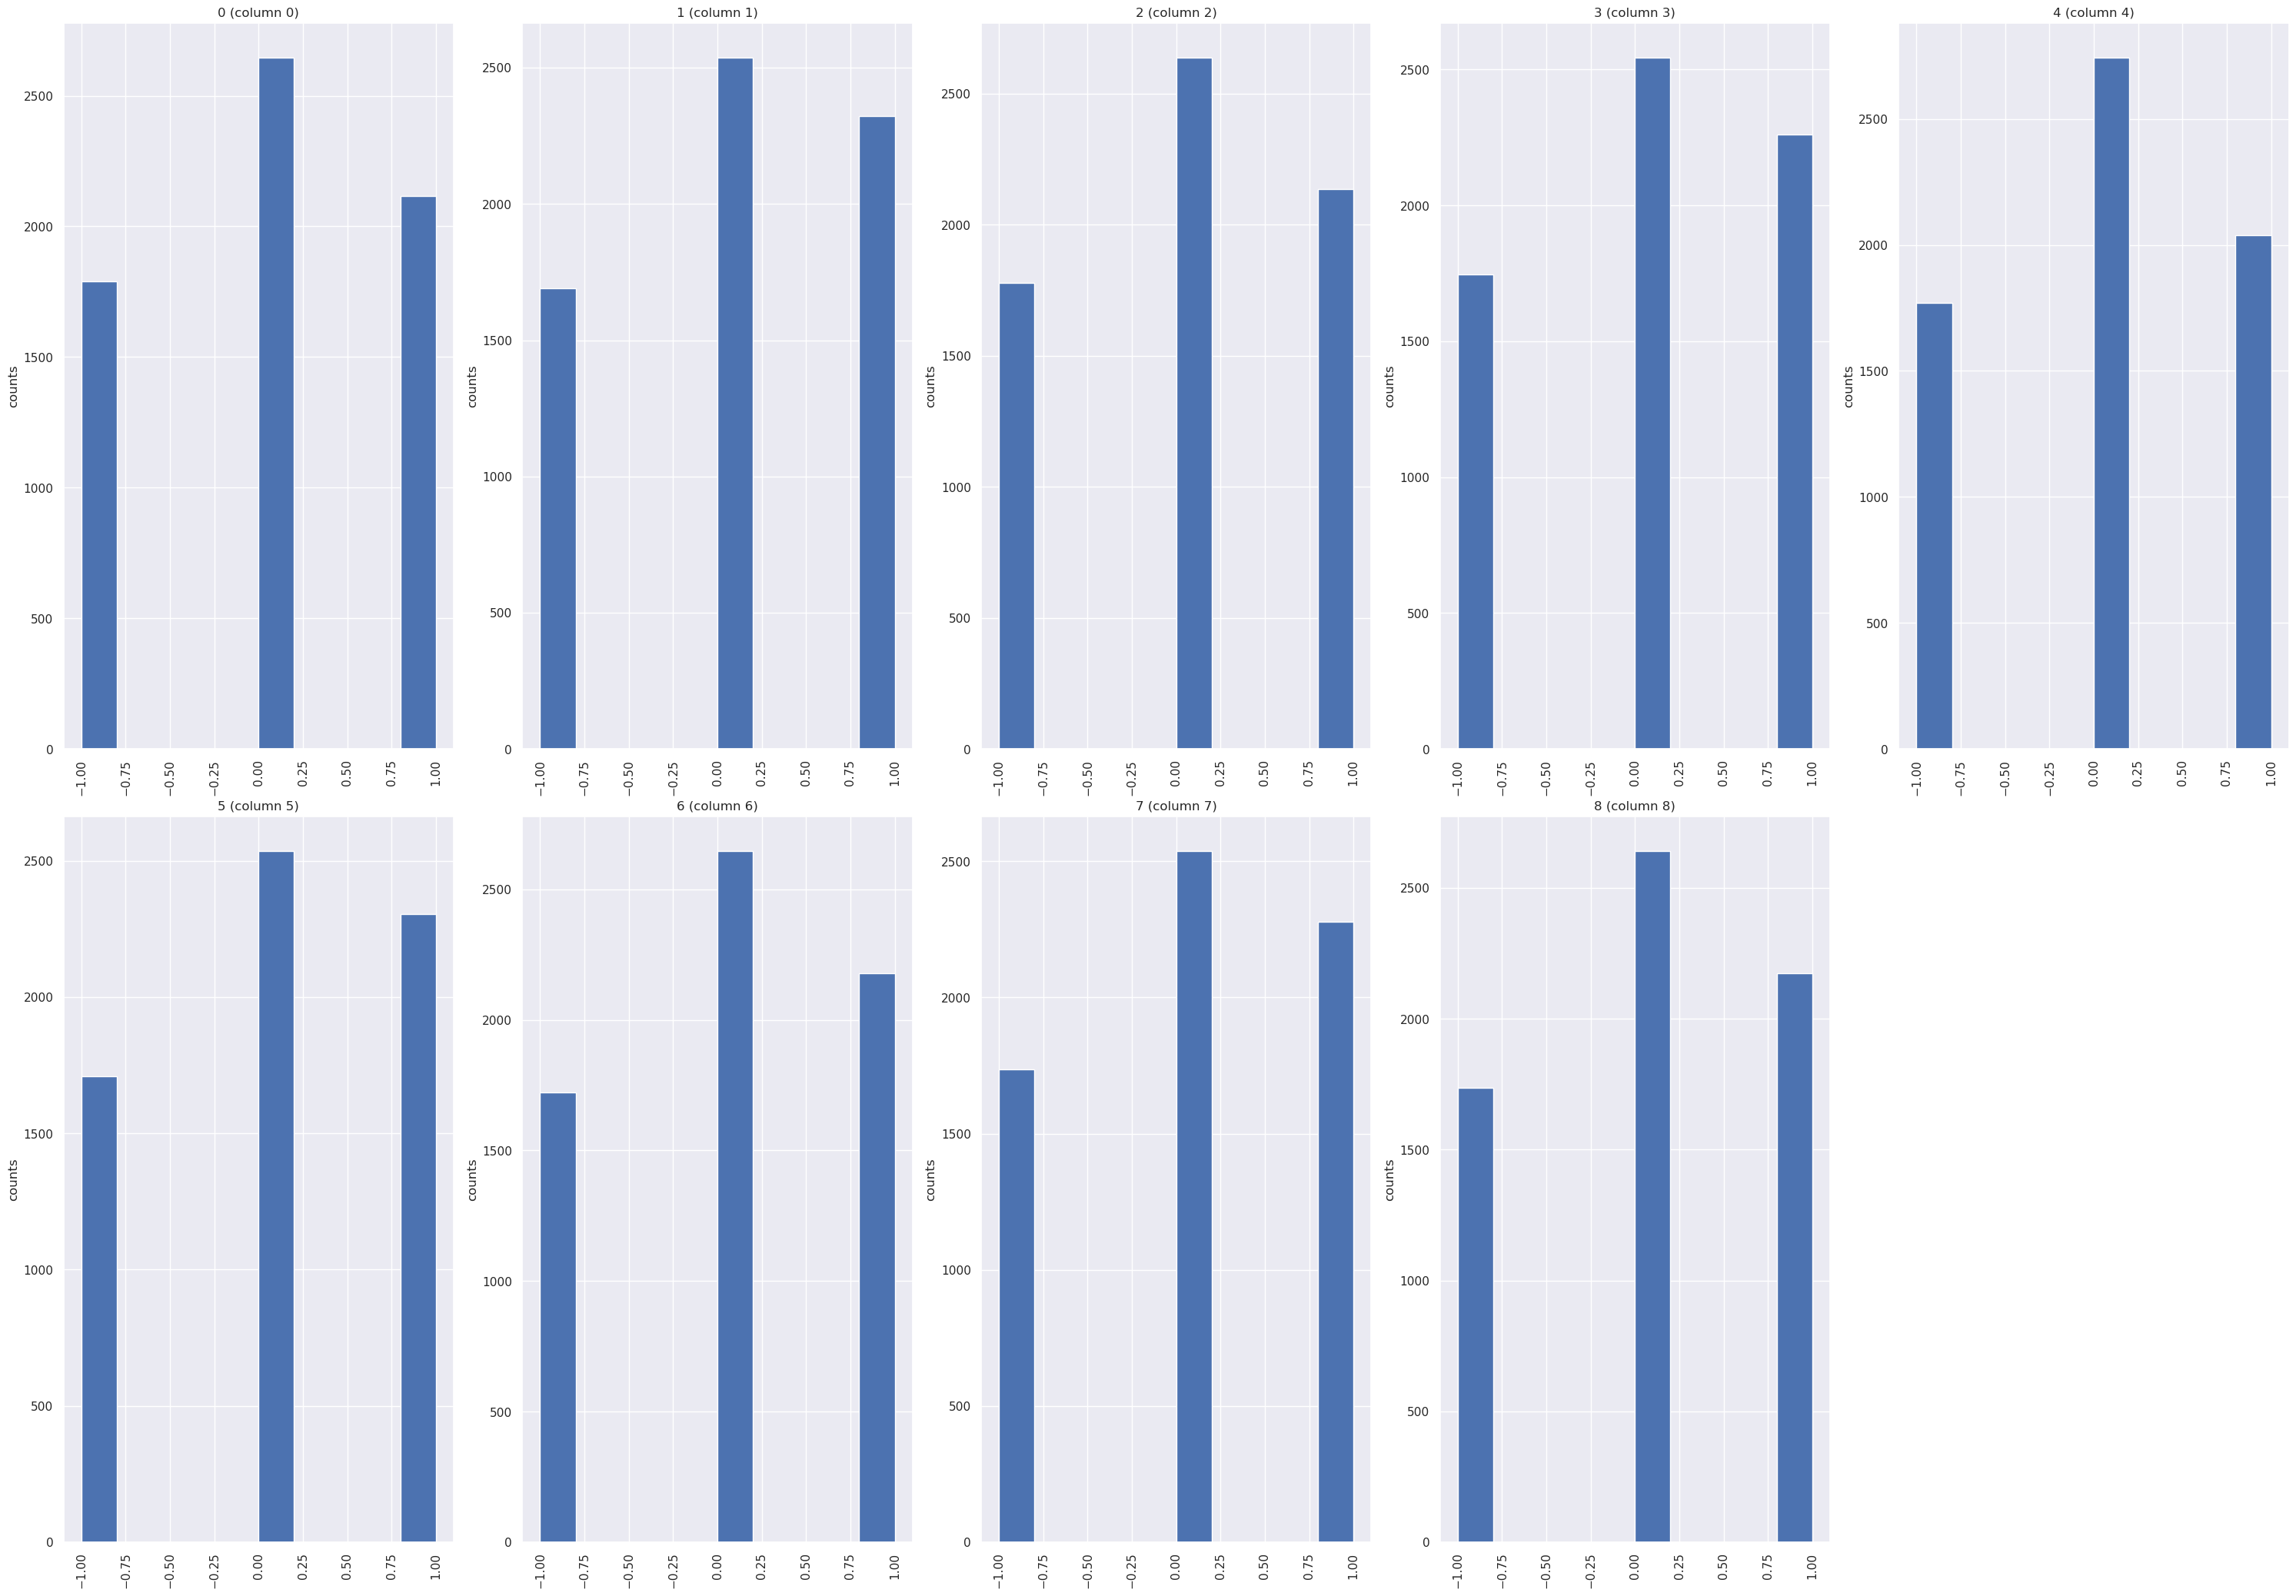

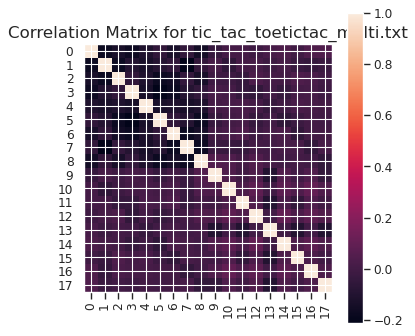

[ 9 10 11 12 13 14 15 16 17]


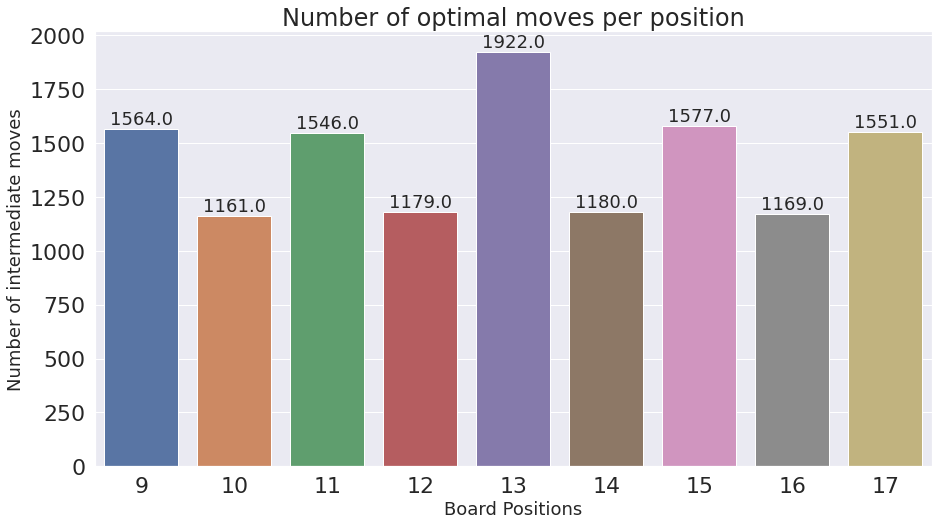

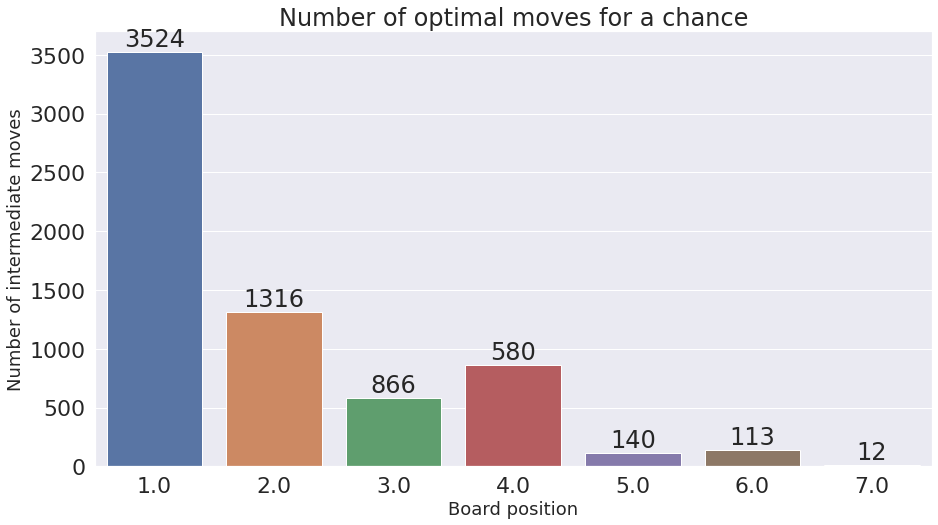

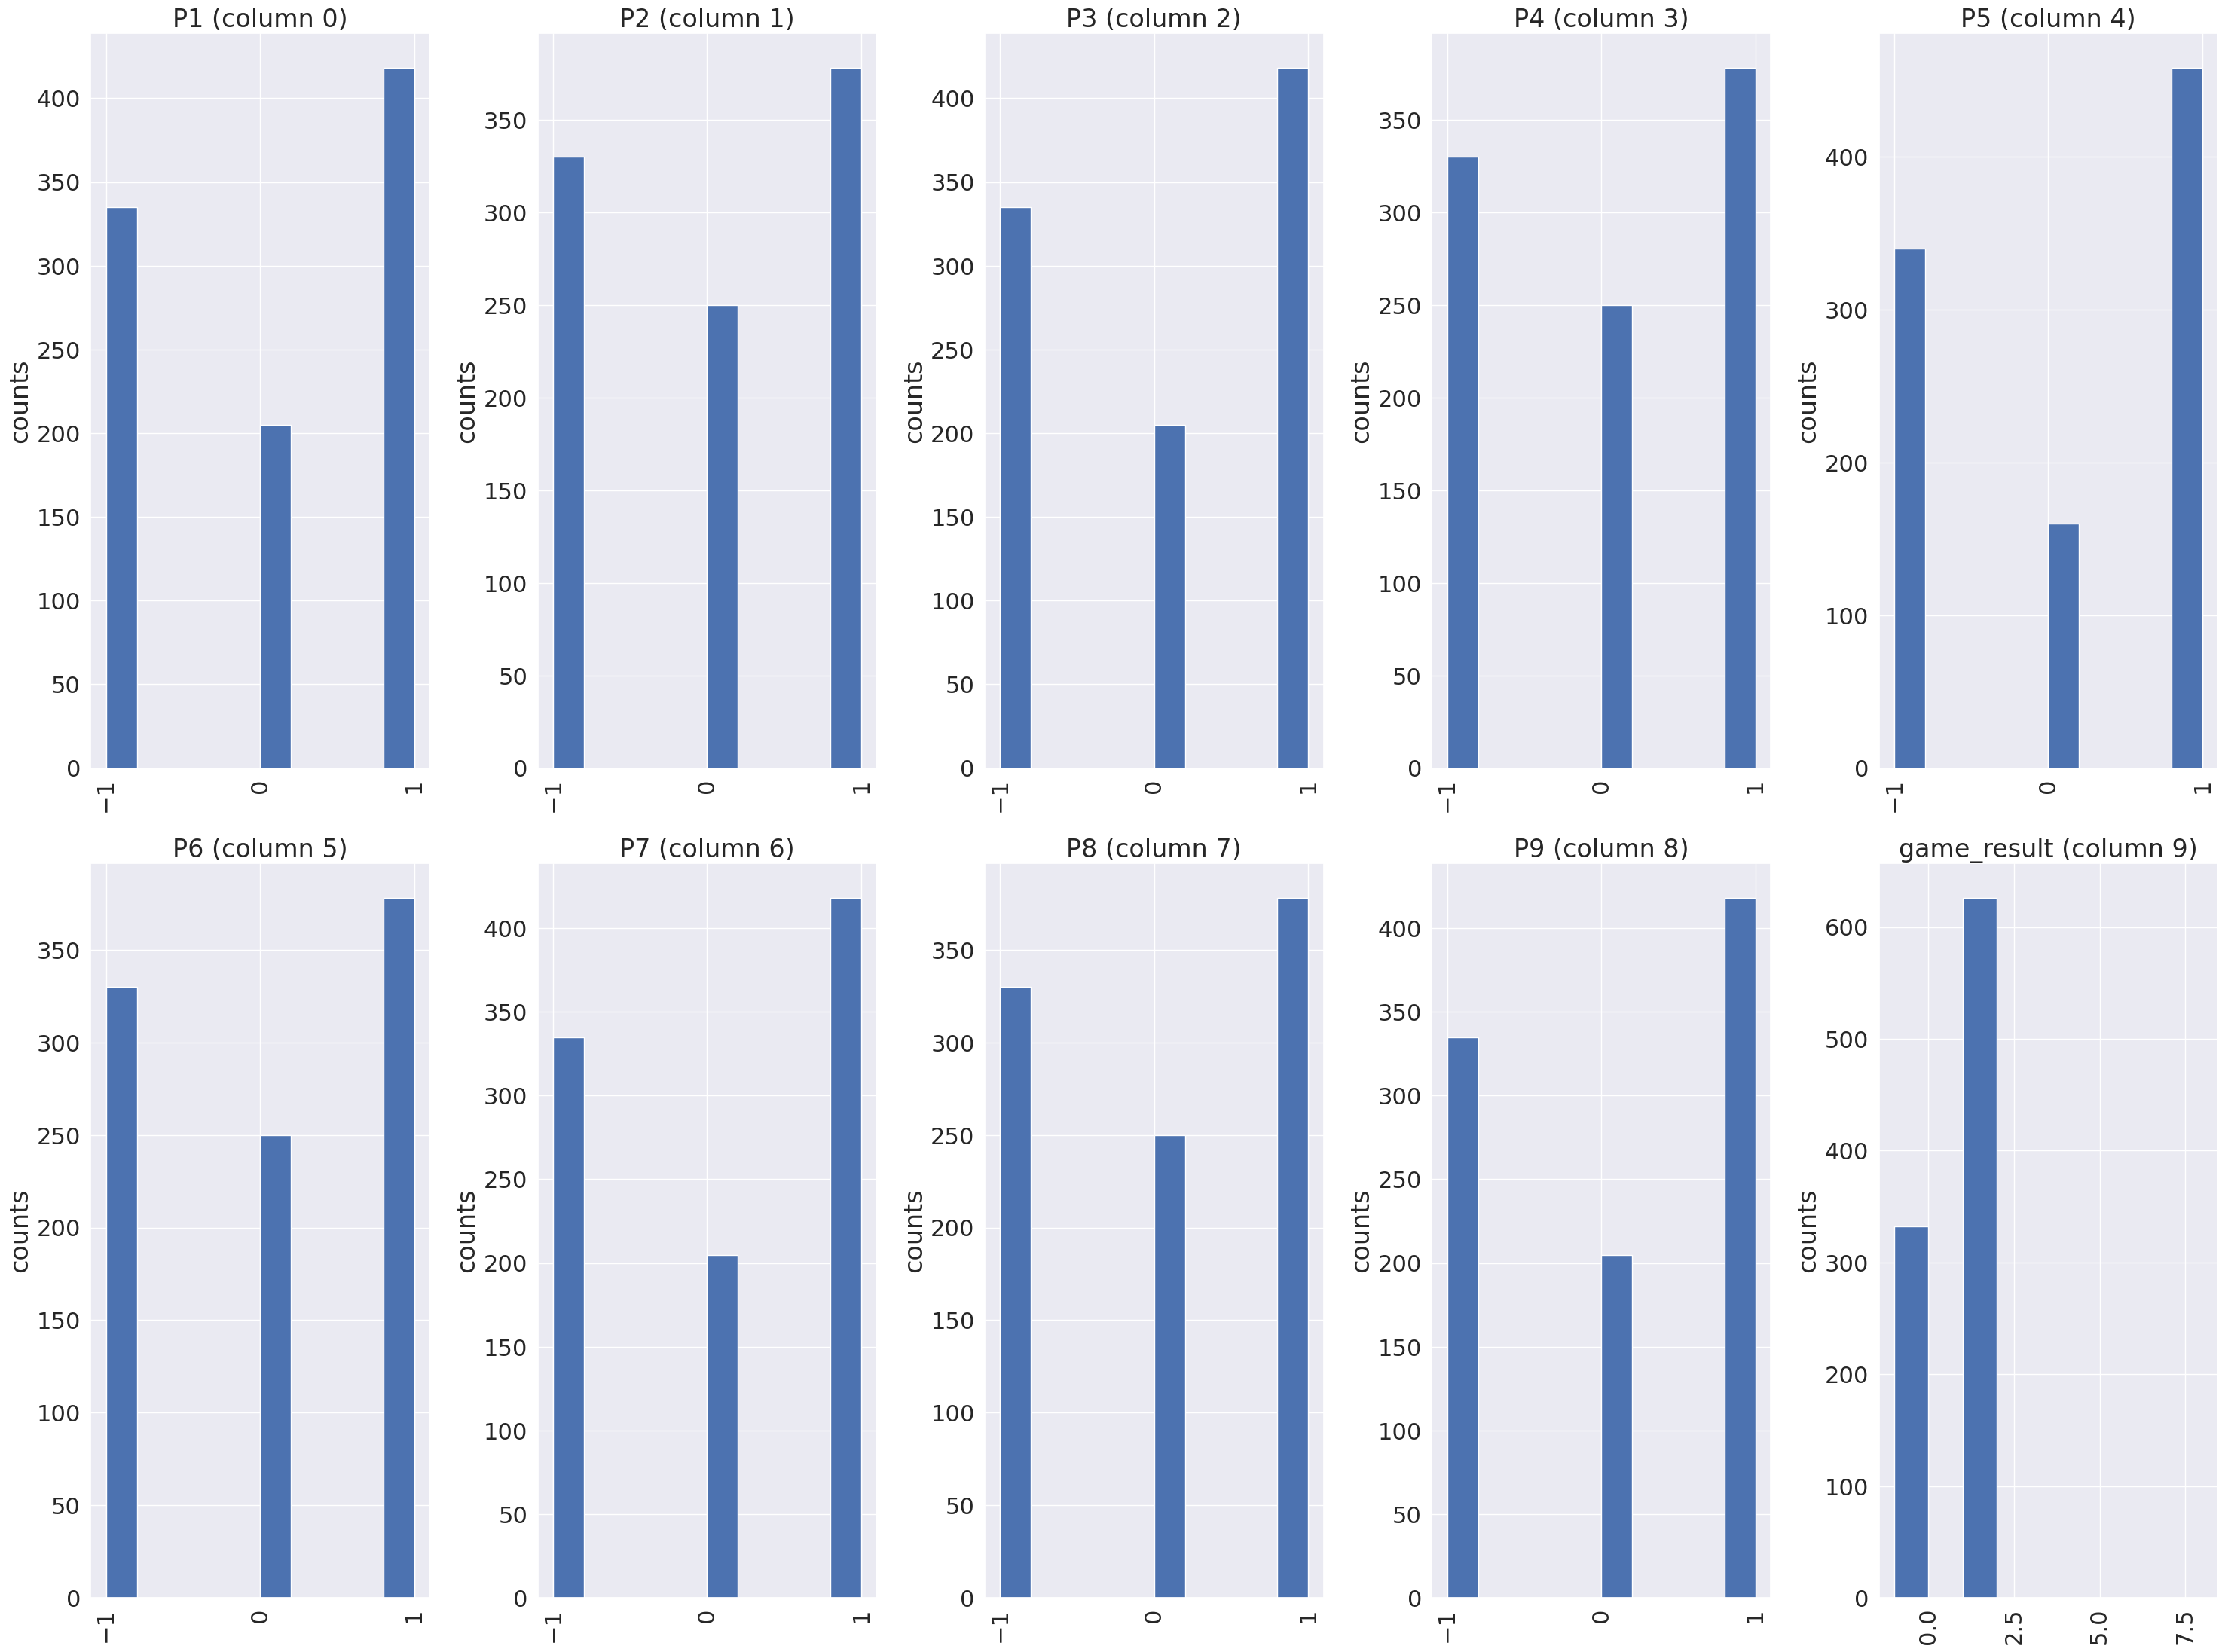

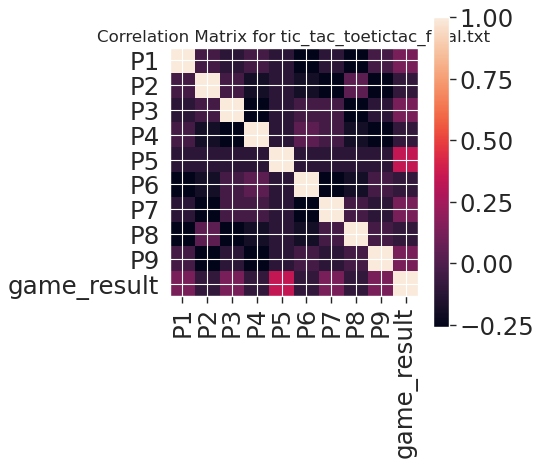

In [26]:
# Distribution graphs (histogram/bar graph) of column data
def plot_per_column_distribution(df, nGraphShown, nGraphPerRow,filename):
    nunique = df.nunique()
    #df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 100, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            if columnDf.name=='game_result':
                columnDf.hist(bins=[-1,0,1,2,3,4,5,6,7,8])
            else:
                columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig(filename+"_histogram.png")
    plt.show()
    
# Correlation matrix
def plot_correlation_matrix(df, graphWidth,filename):
    plot_title = "tic_tac_toe"+filename
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {plot_title}', fontsize=15)
    plt.savefig(plot_title+".png")
    plt.show()

def plot_regressor_moves_distribution(df,loc):
    categories = df.iloc[:,loc:].columns.values
    sn.set(font_scale = 2)
    plt.figure(figsize=(15,8))
    print(categories)
    ax= sn.barplot(categories, df.iloc[:,loc:].sum().values)
    plt.title("Number of optimal moves per position", fontsize=24)
    plt.ylabel('Number of intermediate moves', fontsize=18)
    plt.xlabel('Board Positions', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = df.iloc[:,loc:].sum().values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.show()

def plot_regressor_label_function(df, loc):
    rowSums = df.iloc[:,loc:].sum(axis=1)
    multiLabel_counts = rowSums.value_counts()
    #multiLabel_counts = multiLabel_counts.iloc[1:]
    sn.set(font_scale = 2)
    plt.figure(figsize=(15,8))
    ax = sn.barplot(multiLabel_counts.index, multiLabel_counts.values)
    plt.title("Number of optimal moves for a chance")
    plt.ylabel('Number of intermediate moves', fontsize=18)
    plt.xlabel('Board position', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = multiLabel_counts.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()


def plot_data_graph():
    for filename in filenames:
        file = np.loadtxt('{}{}'.format(file_dir, filename['name']))
        file_type = filename['type']
        if file_type == 'classification':
            df = pd.DataFrame(file, columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','game_result'])
            plot_per_column_distribution(df, 10, 5,filename['name'])
            plot_correlation_matrix(df,5,filename['name']) 
        elif file_type == 'regression':
            df = pd.DataFrame(file)
            plot_per_column_distribution(df.iloc[:,:9], 10, 5,filename['name'])
            plot_correlation_matrix(df,5,filename['name'])
            plot_regressor_moves_distribution (df,9)
            plot_regressor_label_function(df,9)
  
plot_data_graph()

## Split data into train/val/test sets

In [8]:
data_splits = {}

for key, value in data.items():
    # Get train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        value['examples'], 
        value['labels'], 
        test_size=0.4, 
        shuffle=True
    )

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, 
        y_test, 
        test_size=0.5, 
        shuffle=True
    )
    
    data_split = {
        'examples': {
            'train': X_train,
            'val': X_val,
            'test': X_test
        },
        'labels': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }
    
    data_splits[key] = data_split

## Print shape of datasets

In [9]:
# Print shape of datasets
print('----Shape of data before splits----')

for key, value in data.items():
    print('{}:   \texamples={}, labels={}'.format(key, value['examples'].shape, value['labels'].shape))

print('\n----Shape of data after splits----')

for key, value in data_splits.items():
    print(key)
    for split_key, split_data in value.items():
        print('\t{}: \ttrain={}, val={}, test={}'.format(
            split_key, 
            split_data['train'].shape, 
            split_data['val'].shape, 
            split_data['test'].shape
        ))

----Shape of data before splits----
single:   	examples=(6551, 9), labels=(6551,)
multi:   	examples=(6551, 9), labels=(6551, 9)
final:   	examples=(958, 9), labels=(958,)

----Shape of data after splits----
single
	examples: 	train=(3930, 9), val=(1311, 9), test=(1310, 9)
	labels: 	train=(3930,), val=(1311,), test=(1310,)
multi
	examples: 	train=(3930, 9), val=(1311, 9), test=(1310, 9)
	labels: 	train=(3930, 9), val=(1311, 9), test=(1310, 9)
final
	examples: 	train=(574, 9), val=(192, 9), test=(192, 9)
	labels: 	train=(574,), val=(192,), test=(192,)


## Define constants

In [10]:
NUM_SPLITS = 10
THRESHHOLD = 0.25

## Helper functions

In [25]:
def train_cross_val(model, examples, labels, num_splits):
    """Trains models with cross validation and returns the trained models"""
    
    # define k fold parameters
    kf = KFold(n_splits=num_splits, shuffle=True)

    # train models w/ train data
    models = cross_validate(model, examples, labels, cv=kf,
                            return_estimator=True)['estimator']
    
    return models

def round_preds(preds, thresh=THRESHHOLD):
    """Rounds predictions up based on value of threshhold. This should only be used for regressor predictions."""
    
    preds[preds >= thresh] = 1
    preds[preds < thresh] = 0
    
    return preds

def save_model(model, filename):
    """Saves model with the given filename"""

    # save model w/ pickle
    if filename:
        pickle.dump(model, open(filename, 'wb'))

## Train Models
### First define training functions

#### Linear SVM

In [12]:
def linear_svm(examples, labels, num_splits=NUM_SPLITS):
    """Trains a linear SVM and returns cross validation models"""
    
    clf = LinearSVC()
    
    result = train_cross_val(clf , examples, labels, num_splits=num_splits)
    
    return result

#### K-nearest neighbors

In [13]:
def k_nearest_neighbors(examples, labels, n_neighbors=20, 
                        model_type='classifier', num_splits=NUM_SPLITS):
    """Trains a KNN and returns cross validation models"""
    
    if model_type == 'classifier':
        clf = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights='distance'
        )
    elif model_type == 'regressor':
        clf = KNeighborsRegressor(
            n_neighbors=20,
            weights='distance'
        )
    else:
        raise Exception('Model type should be either (classifier, or regressor)')
    
    result = train_cross_val(clf , examples, labels, num_splits=num_splits)
    
    return result

#### Neural Network (MLP)

In [39]:
def mlp(examples, labels, model_type='classifier', num_splits=NUM_SPLITS):
    """Trains an MLP and returns cross validation models"""
    
    if model_type == 'classifier':
        clf = MLPClassifier(
        solver='lbfgs',
        max_iter = 3000,
        early_stopping=True)
        is_regressor=False
    elif model_type == 'regressor':
        clf = MLPRegressor(
        hidden_layer_sizes=(250,200,100),
        max_iter=500, 
        activation = 'relu',
        solver='adam',
        random_state=1)
        is_regressor=True
    else:
        raise Exception('Model type should be either (classifier, or regressor)')
    
    result = train_cross_val(clf , examples, labels, num_splits=num_splits)
    
    return result

#### Linear Regression (implemented from scratch w/ Numpy)

In [24]:
def linearNormEqn(X, y):
    """Normal equation linear regression function using least squares"""
    
    theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(X), X)), np.transpose(X)), y)
    
    return theta

def linear_reg(examples, labels):
    """Perform linear regression and return trained model"""
    
    n_cols = labels.shape[1]
    
    # add column of ones to example features (for bias)
    examples = np.append(np.ones((examples.shape[0], 1)), examples, 1)
    
    # Hold all thetas for each label regressor
    thetas = np.zeros((n_cols, examples.shape[1]))

    # Loop through labels and save thetas
    for i in range(n_cols):
        thetas[i] = linearNormEqn(examples, labels[:,i])
    
    return MyLinear(thetas)

def linear_reg_cross_val(examples, labels, num_splits=NUM_SPLITS):
    kf = KFold(n_splits=num_splits, shuffle=True)
    
    models = []
    
    for train_index, test_index in kf.split(examples):
        X_train = examples[train_index]
        y_train = labels[train_index]
        
        models.append(linear_reg(X_train, y_train))
    
    return models

## Find optimal hyperparameters for linear and KNN models using train/validation sets
- Find the optimal threshhold rounding values to round regression models to their classifier predictions
- For the **KNN** model, also find the optimal number of neighbors

In [16]:
def find_opt_thresh(trained_model, examples_val, labels_val, thresh_vals):
    # def threshhold values to try
    optimal_thresh = thresh_vals[0]
    best_fscore = 0

    # make predictions on validation set (don't round regressors to classifiers yet)
    preds = predict_cross_val(trained_model, examples_val)

    for thresh in thresh_vals:
        # round predictions with this specific threshhold
        rounded_preds = round_preds(preds.copy(), thresh)

        # evaluate metrics with this specific threshhold on the validation labels
        model_metrics = metrics.classification_report(labels_val, rounded_preds, 
                                                      output_dict=True, zero_division=0)

        # get average f1-score
        avg_fscore = np.mean([model_metrics[label_key]['f1-score'] for label_key in [key for key in '012345678']])
        
        # update optimal thresh if it has a better average fscore
        if avg_fscore > best_fscore:
            best_fscore = avg_fscore
            optimal_thresh = thresh

    return optimal_thresh

### Find optimal threshold for **linear** model using validation set

In [17]:
trained_model = linear_reg_cross_val(data_splits['multi']['examples']['train'], 
                                     data_splits['multi']['labels']['train'])

optimal_thresh_linear = find_opt_thresh(trained_model, data_splits['multi']['examples']['val'],
                                        data_splits['multi']['labels']['val'], 
                                        np.linspace(.05, .4, 25))

print('Optimal threshhold value for linear regression rounding: {}'.format(optimal_thresh_linear))

Optimal threshhold value for linear regression rounding: 0.15208333333333335


### Find optimal threshold value for **KNN** using validation set

In [18]:
trained_model = k_nearest_neighbors(data_splits['multi']['examples']['train'], 
                                    data_splits['multi']['labels']['train'],
                                    model_type='regressor')

optimal_thresh_knn = find_opt_thresh(trained_model, data_splits['multi']['examples']['val'],
                                        data_splits['multi']['labels']['val'], 
                                        np.linspace(.3, .8, 25))

print('Optimal threshhold value for KNN regression rounding: {}'.format(optimal_thresh_knn))

Optimal threshhold value for KNN regression rounding: 0.4041666666666667


### Find optimal threshold value for **MLP** using validation set

In [36]:
trained_model = mlp(data_splits['multi']['examples']['train'], 
                    data_splits['multi']['labels']['train'],
                    model_type='regressor')

optimal_thresh_mlp = find_opt_thresh(trained_model, data_splits['multi']['examples']['val'],
                                        data_splits['multi']['labels']['val'], 
                                        [np.linspace(.3, .8, 25)])

print('Optimal threshhold value for MLP regression rounding: {}'.format(optimal_thresh_mlp))

/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/apps/python/3.8/lib/python3.8/site-packages/

KeyboardInterrupt: 

### Final optimal n nearest neighbors for **KNN** model

In [20]:
# def n values to try
n_vals = np.linspace(5, 30, 5).astype(int)
optimal_n = n_vals[0]
best_fscore = 0

for n in n_vals:
    print('Trying n={}'.format(n))
    # train knn regression model
    trained_knn_model = k_nearest_neighbors(data_splits['multi']['examples']['train'], 
                                            data_splits['multi']['labels']['train'], 
                                            model_type='regressor', n_neighbors=n)
    
    # make predictions on validation set
    preds = predict_cross_val(trained_knn_model, data_splits['multi']['examples']['val'])
    preds = round_preds(preds, optimal_thresh_knn)
    
    # evaluate metrics with this specific threshhold on the validation labels
    knn_metrics = metrics.classification_report(data_splits['multi']['labels']['val'], preds, 
                                                output_dict=True, zero_division=0)
    
    # get average f1-score
    avg_fscore = np.mean([knn_metrics[label_key]['f1-score'] for label_key in [key for key in '012345678']])
    
    if avg_fscore > best_fscore:
        avg_fscore = best_fscore
        optimal_n = n

print('Optimal n value for KNN regressor: {}'.format(n))

Trying n=5
Trying n=11
Trying n=17
Trying n=23
Trying n=30
Optimal n value for KNN regressor: 30


### Now train all three models (***linear***, ***k-nearest***, and ***MLP***) on both classifier datasets (***single*** and ***final***) and the one regressor dataset (***multi***)
- Train with the train dataset
- Test with the test dataset
- Save the predictions in the **predictions** dictionary

In [21]:
predictions = {}

# This loops over each dataset, trains each of the classifiers, and saves the predictions
for dataset_name in ['single', 'final', 'multi']:
    predictions[dataset_name] = {}
    print('Evaluating the {} dataset'.format(dataset_name))
    
    if dataset_name in ['single', 'final']:
        print('\tPerforming linear SVM...')
        model = linear_svm(data_splits[dataset_name]['examples']['train'], 
                           data_splits[dataset_name]['labels']['train'])
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'], is_regressor=False, num_labels=1)
        predictions[dataset_name]['linear'] = preds

        print('\tPerforming k-nearest neighbors...')
        model = k_nearest_neighbors(data_splits[dataset_name]['examples']['train'], 
                                    data_splits[dataset_name]['labels']['train'], model_type='classifier')
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'], is_regressor=False, num_labels=1)
        predictions[dataset_name]['knn'] = preds

        print('\tPerforming multilayer perceptron...')
        model = mlp(data_splits[dataset_name]['examples']['train'], 
                    data_splits[dataset_name]['labels']['train'], model_type='classifier')
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'], is_regressor=False, num_labels=1)
        predictions[dataset_name]['mlp'] = preds
    elif dataset_name == 'multi':
        print('\tPerforming linear regression...')
        model = linear_reg_cross_val(data_splits[dataset_name]['examples']['train'], data_splits['multi']['labels']['train'])
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'])
        preds = round_preds(preds, optimal_thresh_linear)
        save_model(model, 'linear.sav')
        predictions[dataset_name]['linear'] = preds

        print('\tPerforming k-nearest neighbors...')
        model = k_nearest_neighbors(data_splits[dataset_name]['examples']['train'], 
                                    data_splits[dataset_name]['labels']['train'], model_type='regressor',
                                    n_neighbors=optimal_n)
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'])
        preds = round_preds(preds, optimal_thresh_knn)
        save_model(model, 'knn.sav')
        predictions[dataset_name]['knn'] = preds

        print('\tPerforming multilayer perceptron...')
        model = mlp(data_splits[dataset_name]['examples']['train'], 
                    data_splits[dataset_name]['labels']['train'], model_type='regressor')
        preds = predict_cross_val(model, data_splits[dataset_name]['examples']['test'])
        preds = round_preds(preds, optimal_thresh_mlp)
        save_model(model, 'mlp.sav')
        predictions[dataset_name]['mlp'] = preds

Evaluating the single dataset
	Performing linear SVM...
	Performing k-nearest neighbors...
	Performing multilayer perceptron...
Evaluating the final dataset
	Performing linear SVM...
	Performing k-nearest neighbors...
	Performing multilayer perceptron...
Evaluating the multi dataset
	Performing linear regression...
	Performing k-nearest neighbors...
	Performing multilayer perceptron...


/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/apps/python/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

### Display confusion matrices

In [22]:
# Make directory to save images
cm_dir = 'confusion_matrices'
if not os.path.isdir(cm_dir):
    os.mkdir(cm_dir)
    
sn.set(font_scale=1)

def display_confusion_matrix(ground_truth, preds, title, labels):
    c_matrix = metrics.confusion_matrix(ground_truth, preds, normalize='all')
    
    labels = labels.astype(int)
    
    df_cm = pd.DataFrame(c_matrix, index = labels,
                  columns = labels)
    ax = sn.heatmap(df_cm, cmap="Blues", annot=True, cbar=True)
    ax.set()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.title(title, fontsize=26)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    plt.savefig('{}/{}'.format(cm_dir, title), dpi=100)
    
    plt.show()

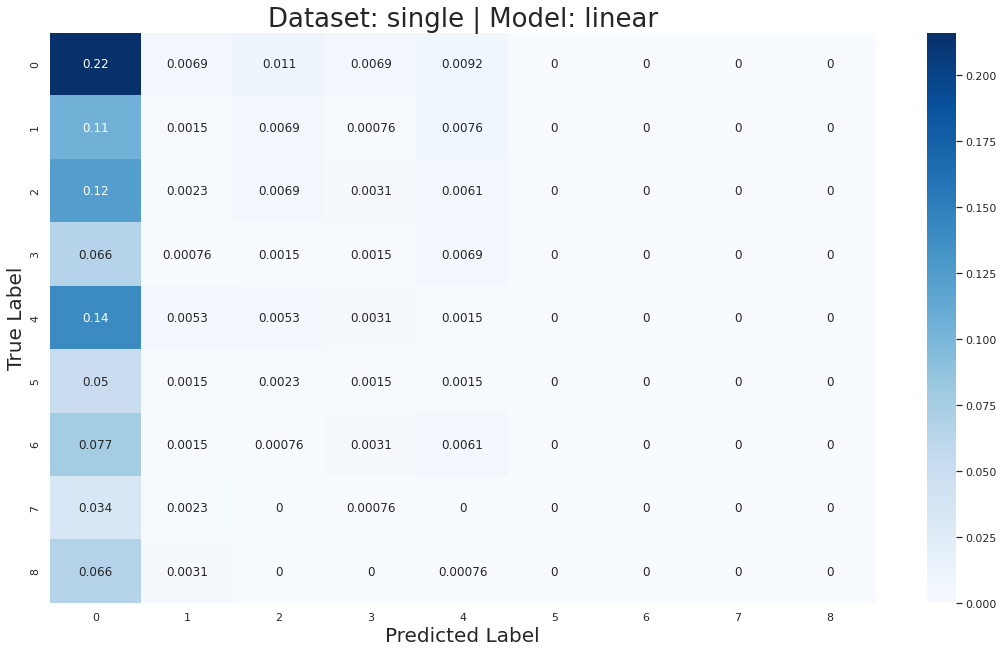

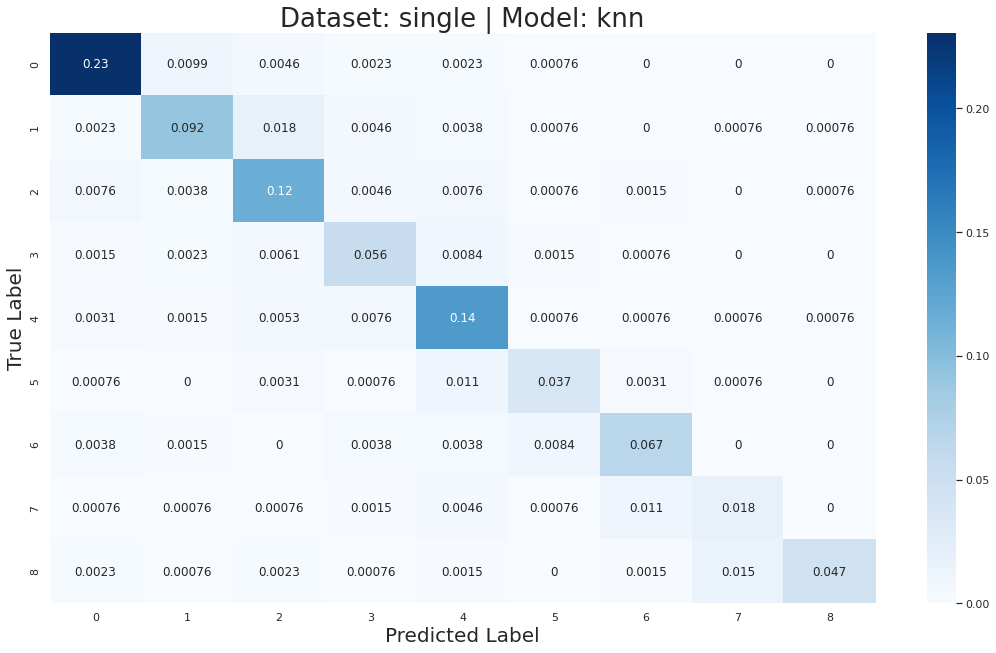

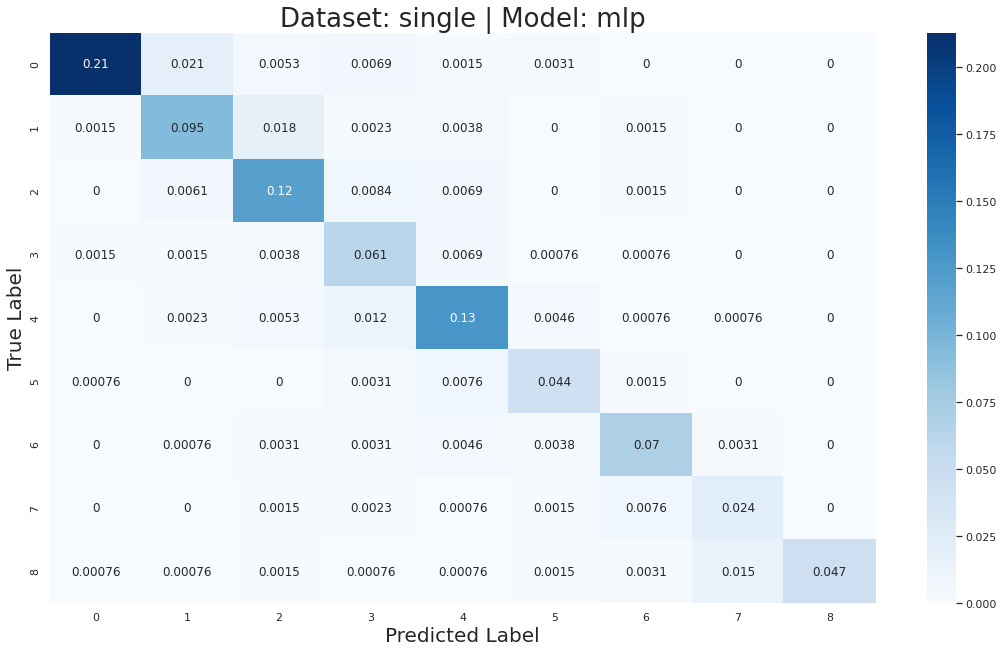

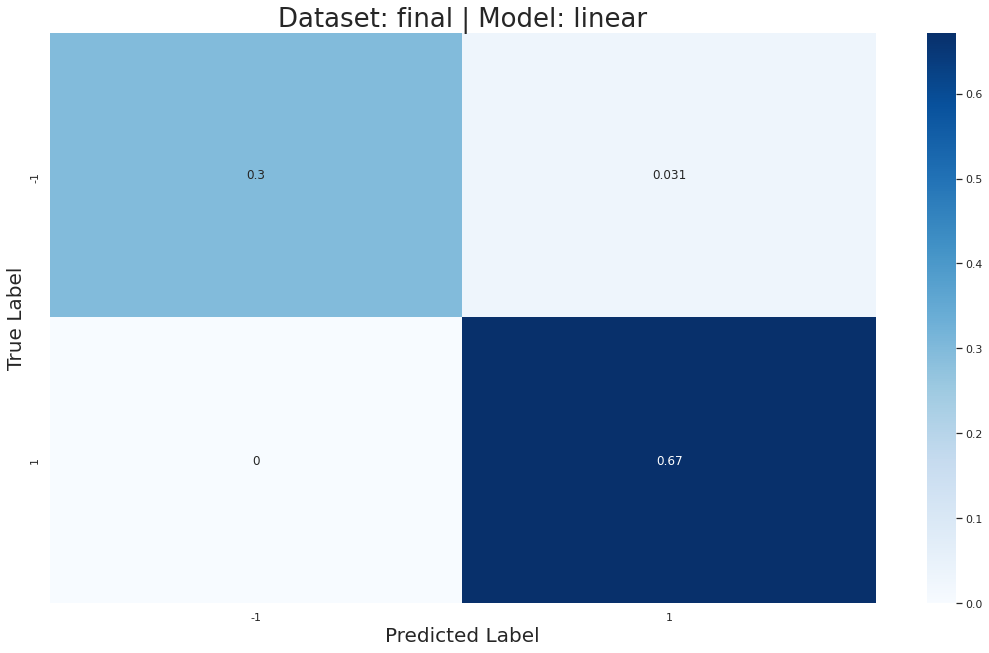

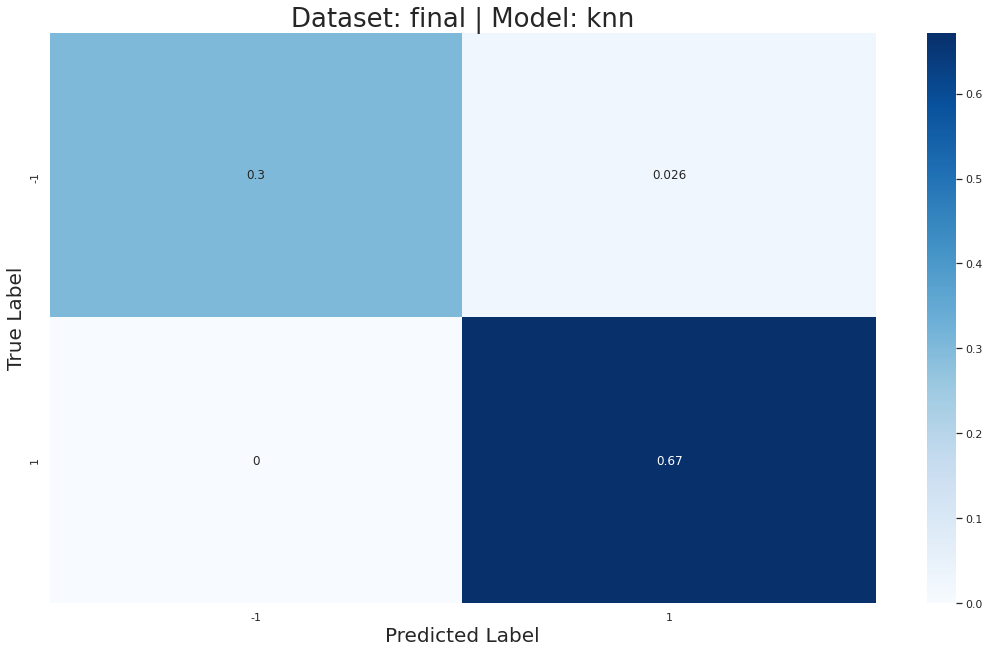

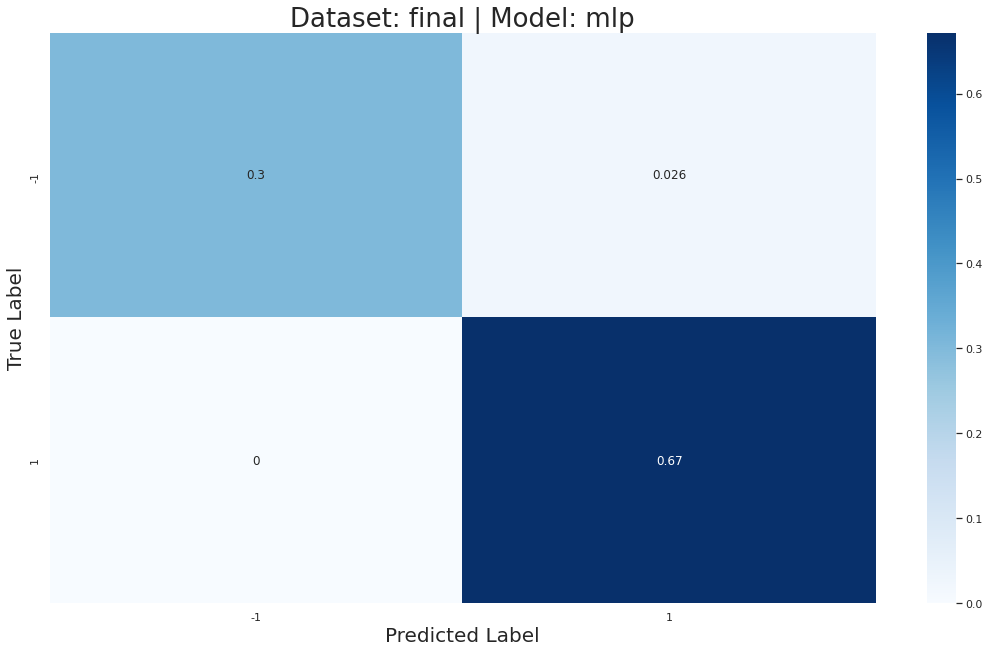

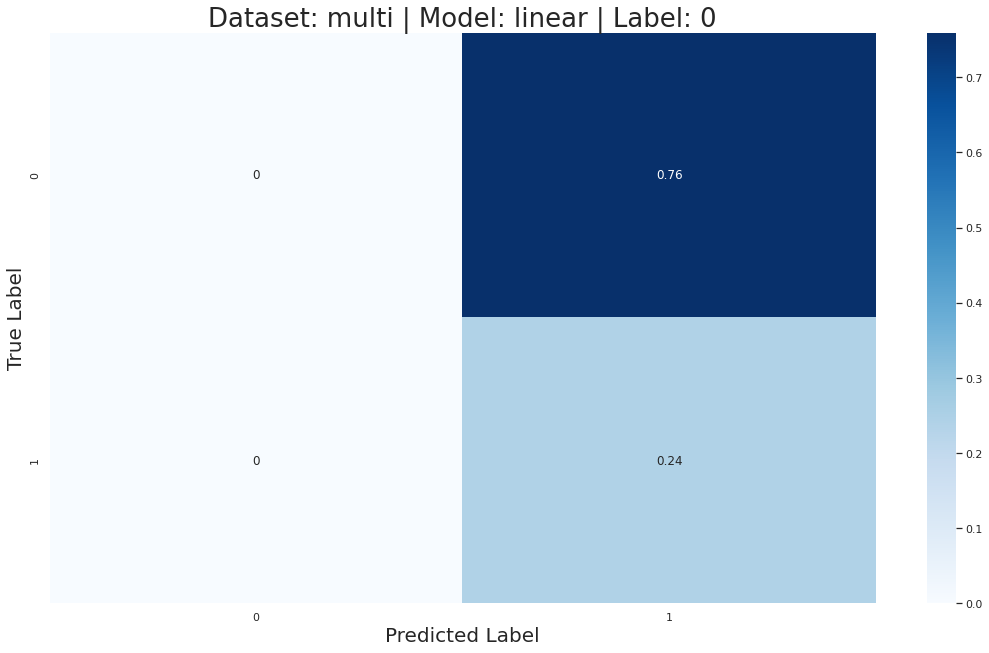

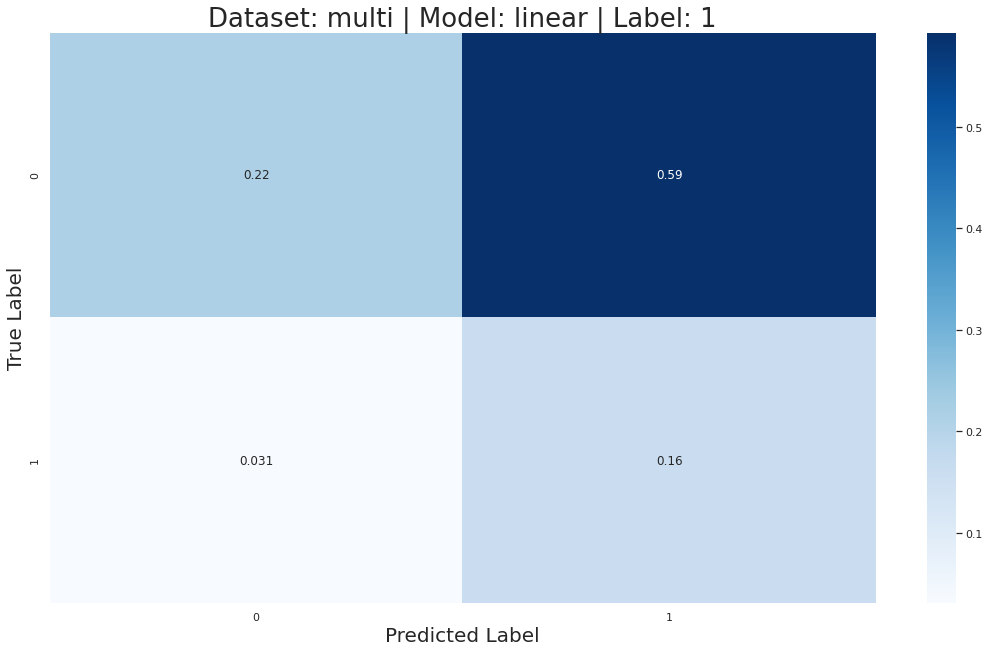

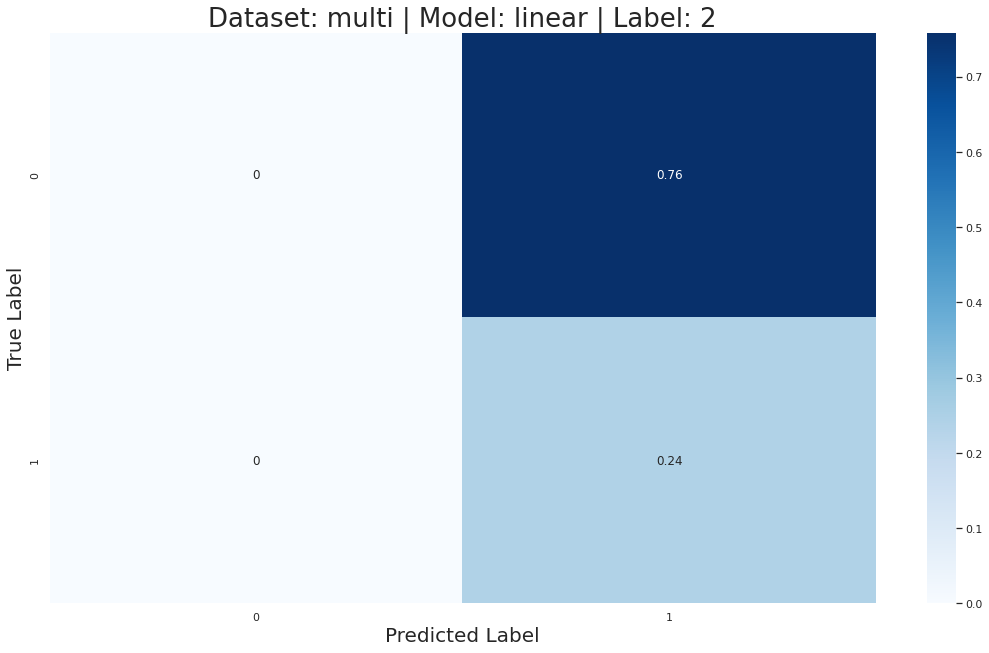

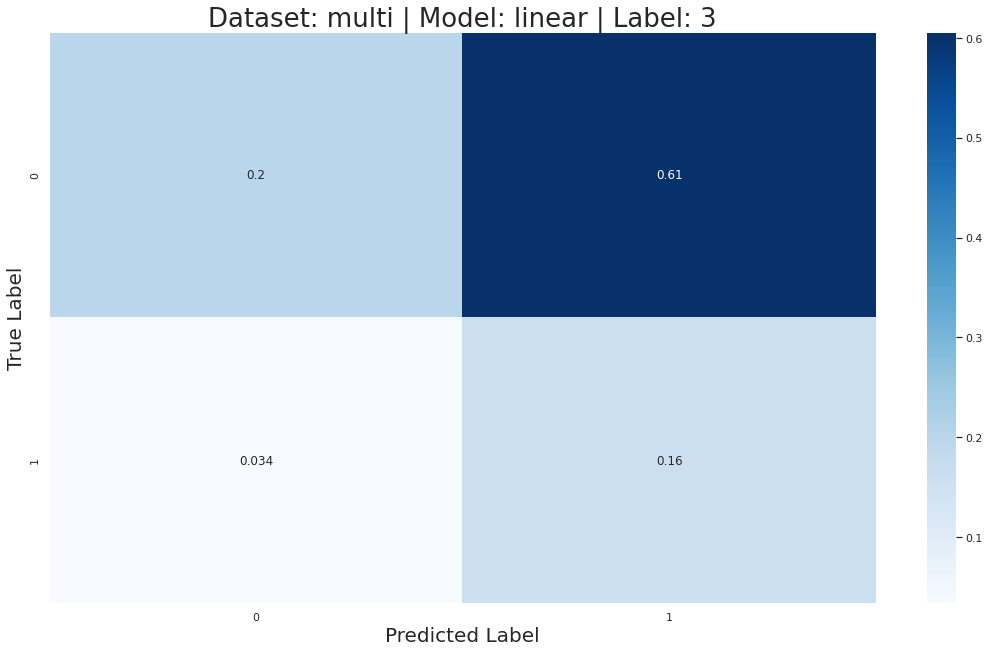

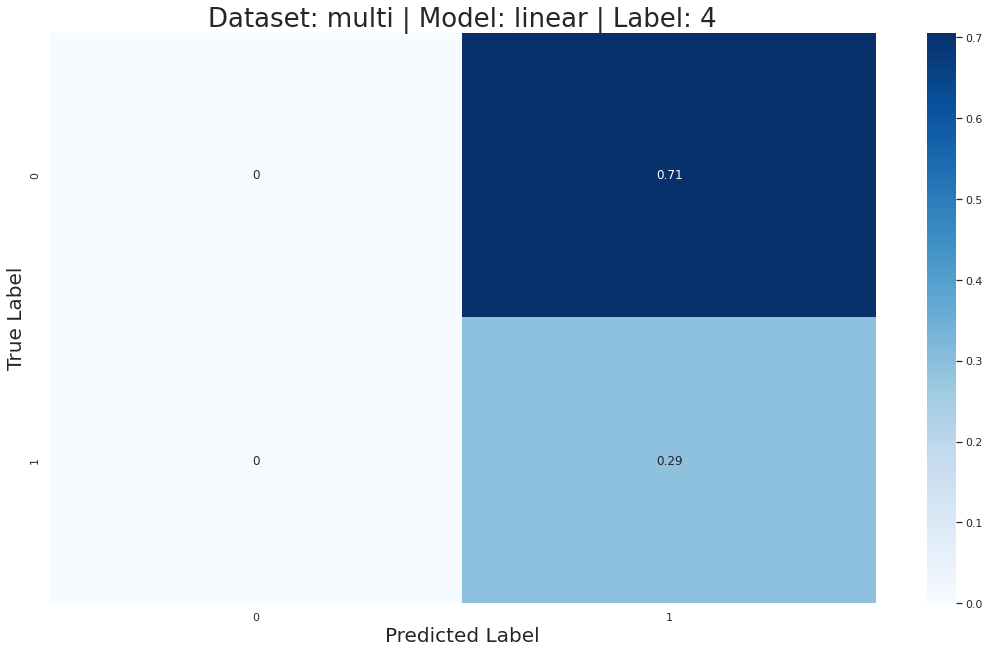

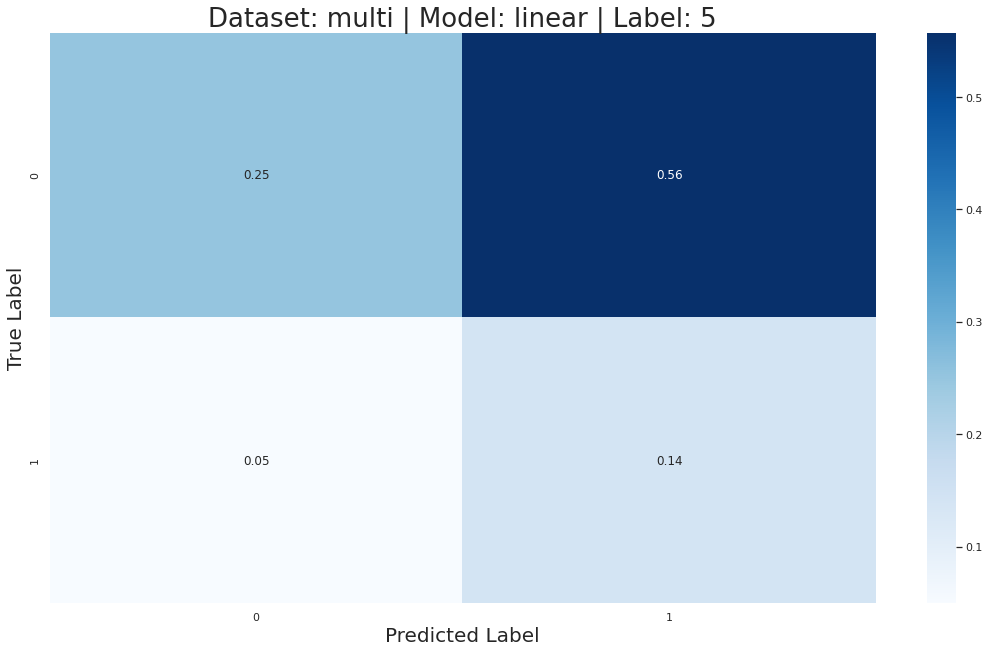

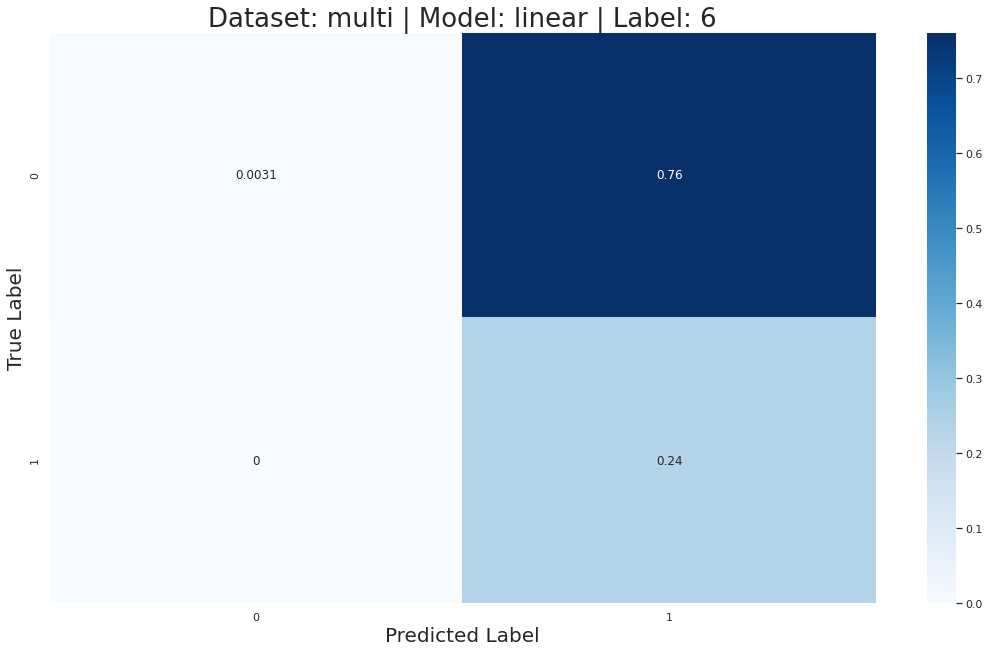

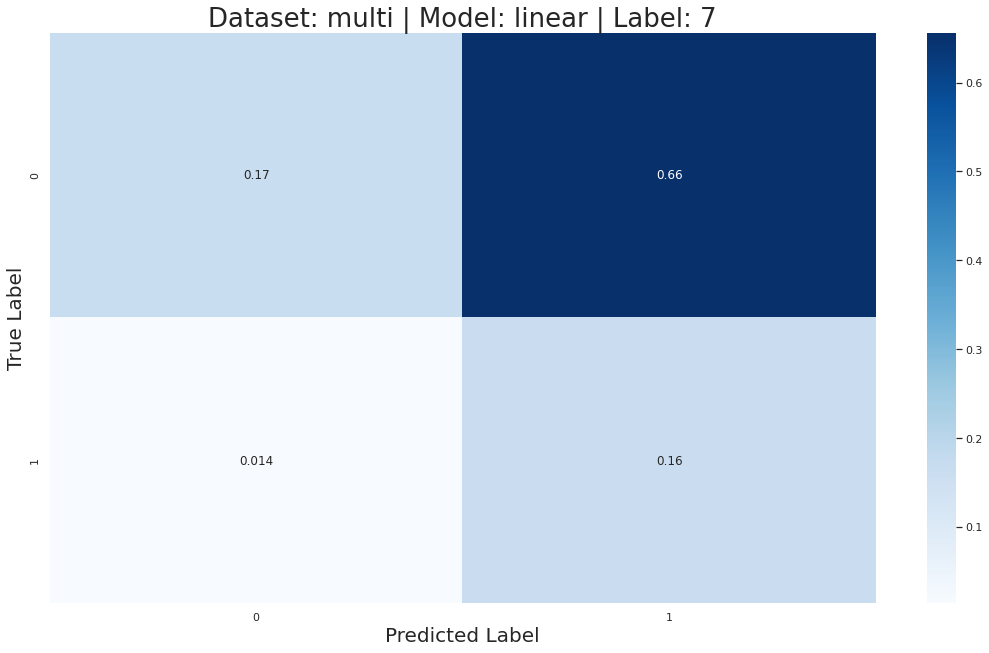

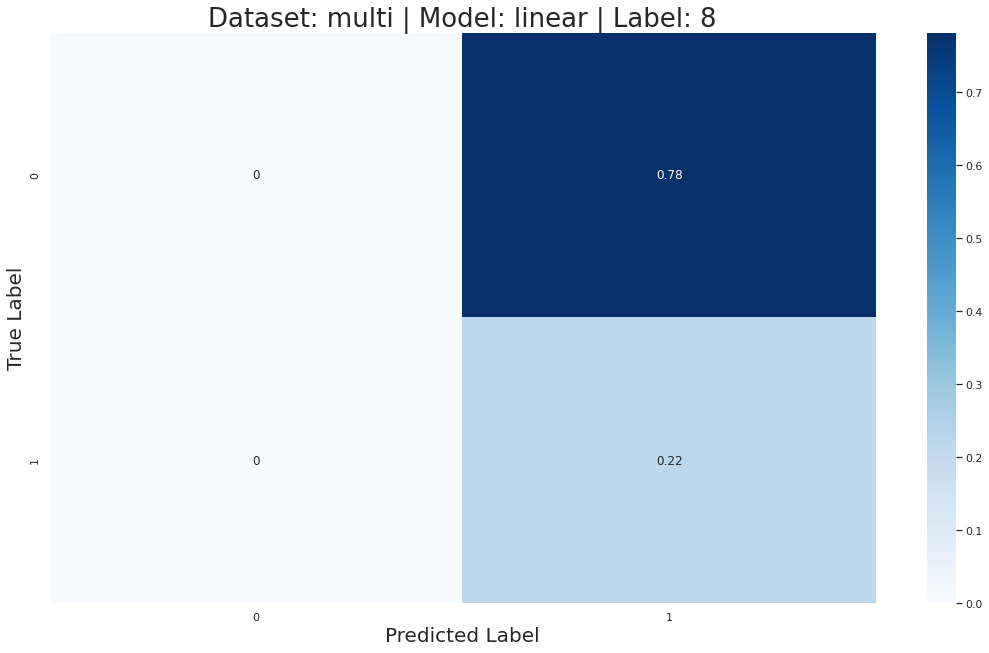

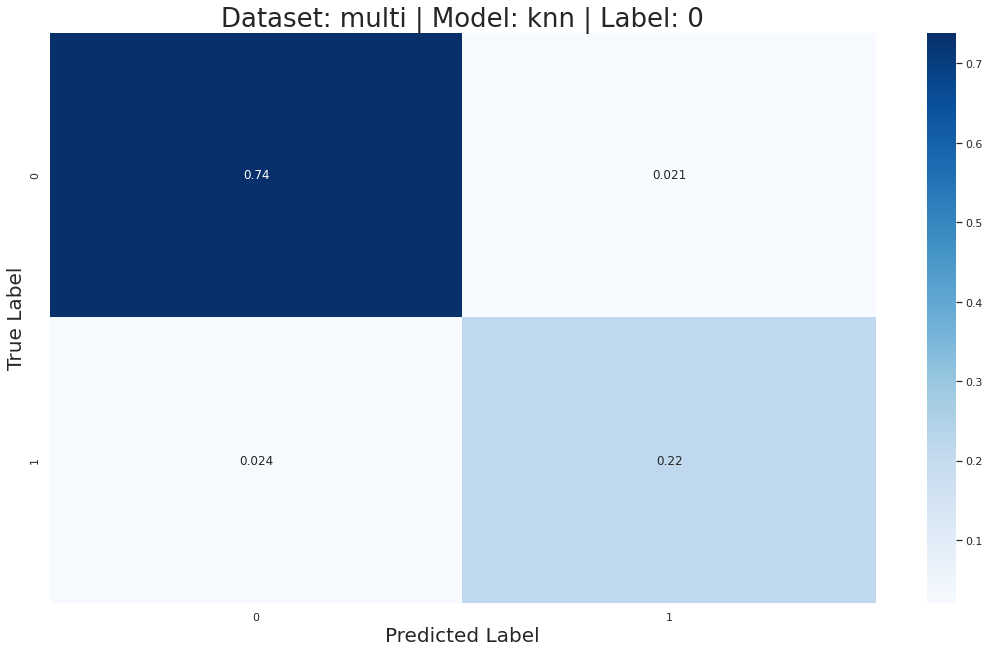

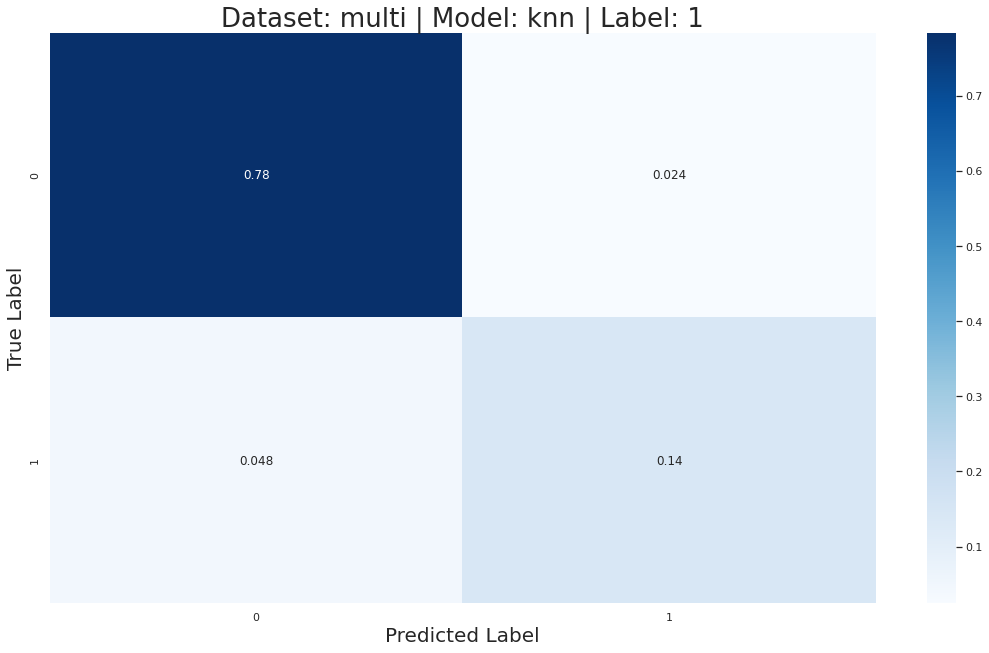

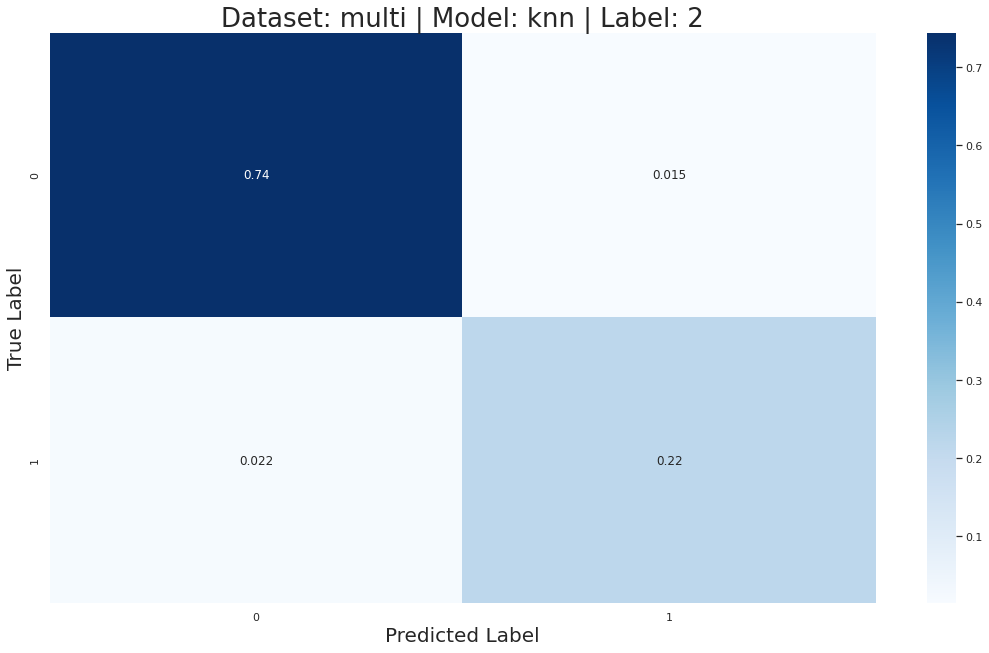

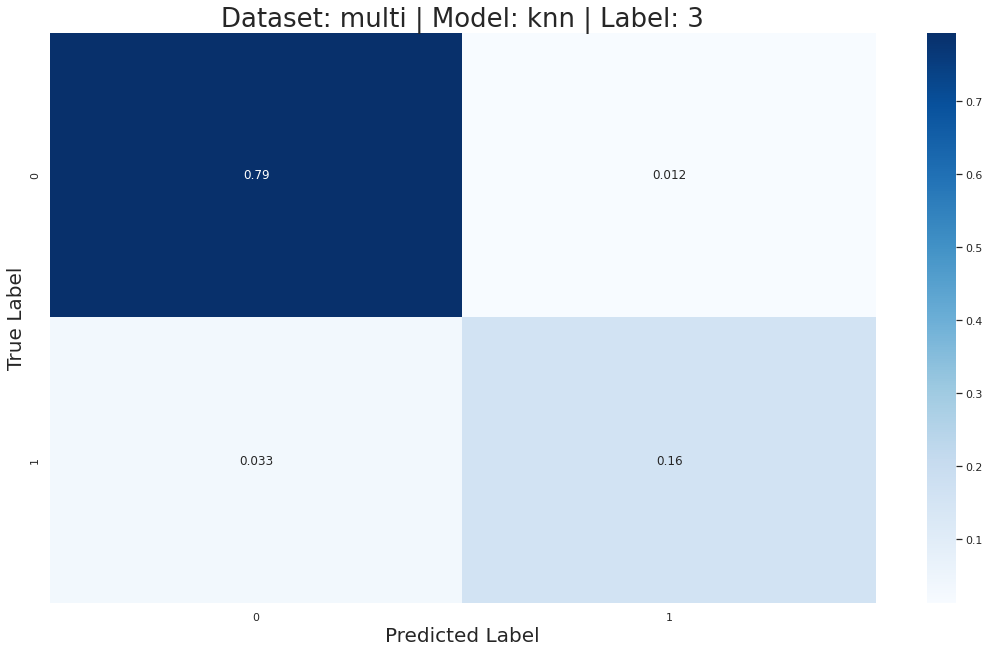

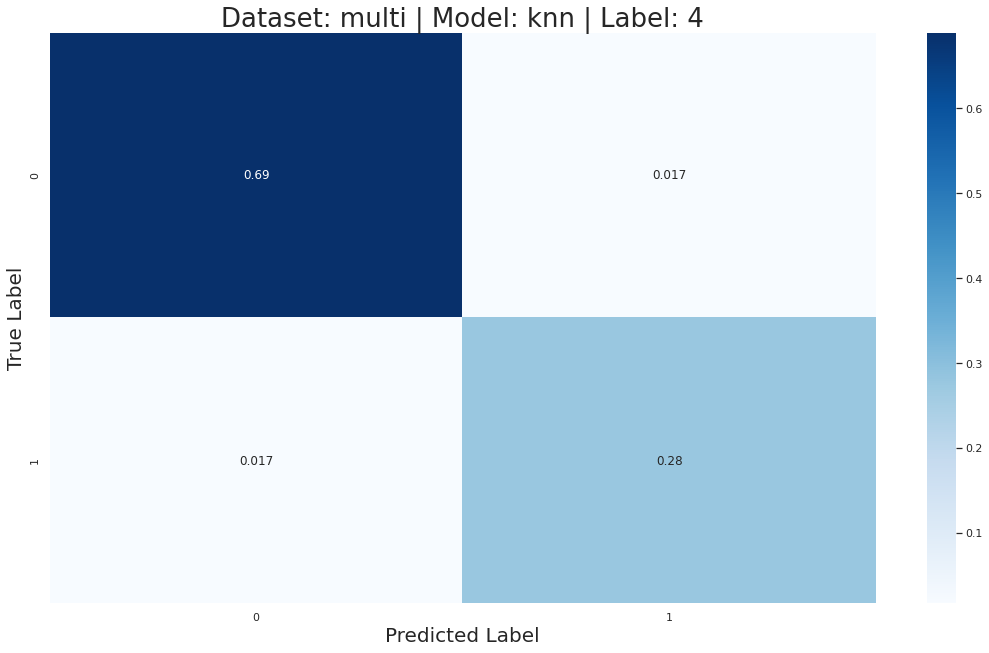

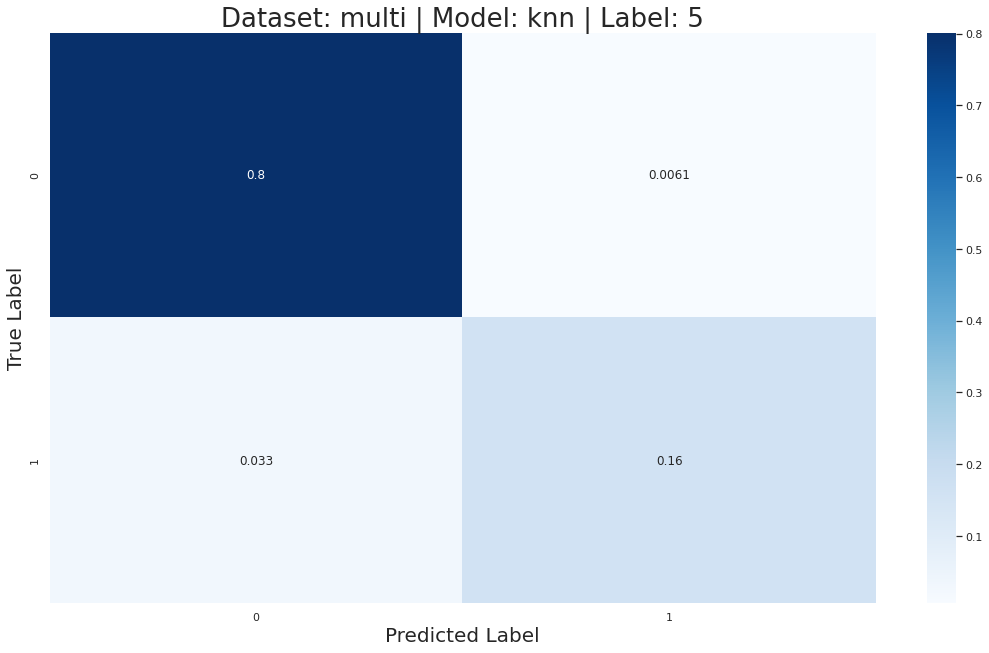

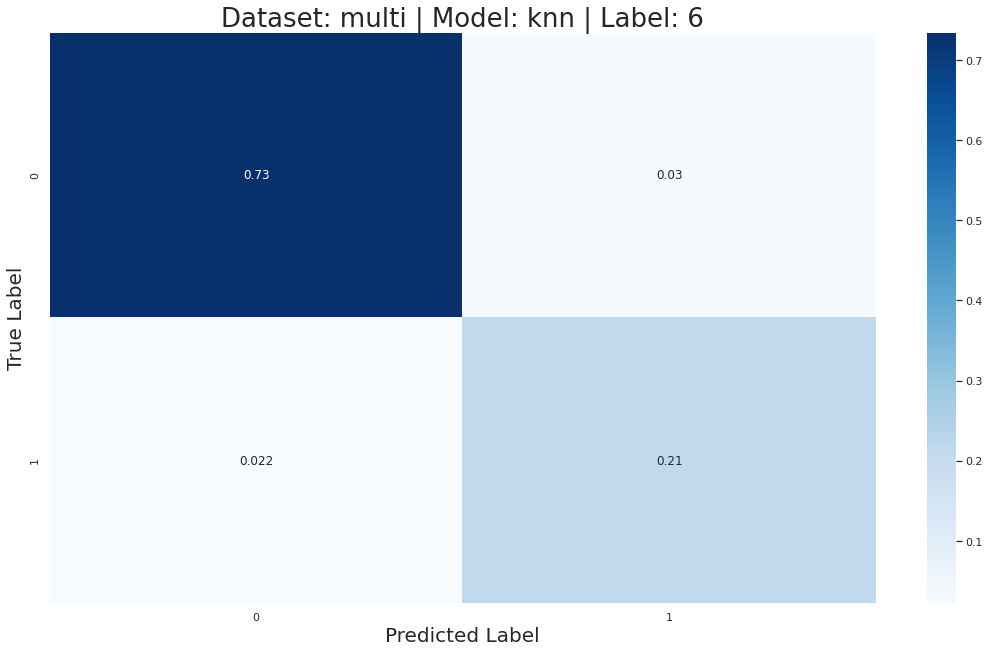

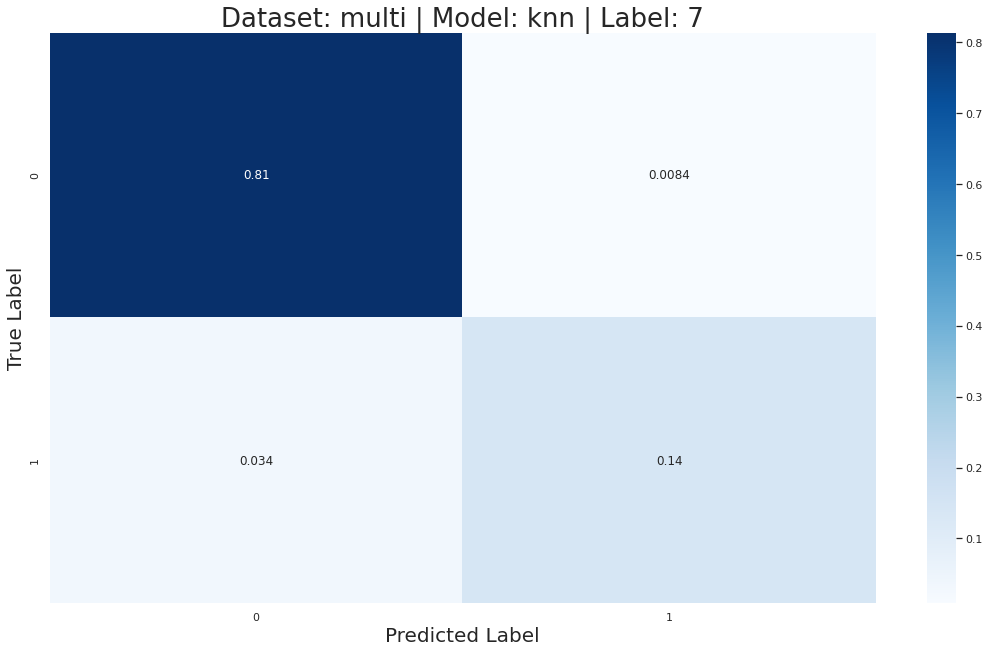

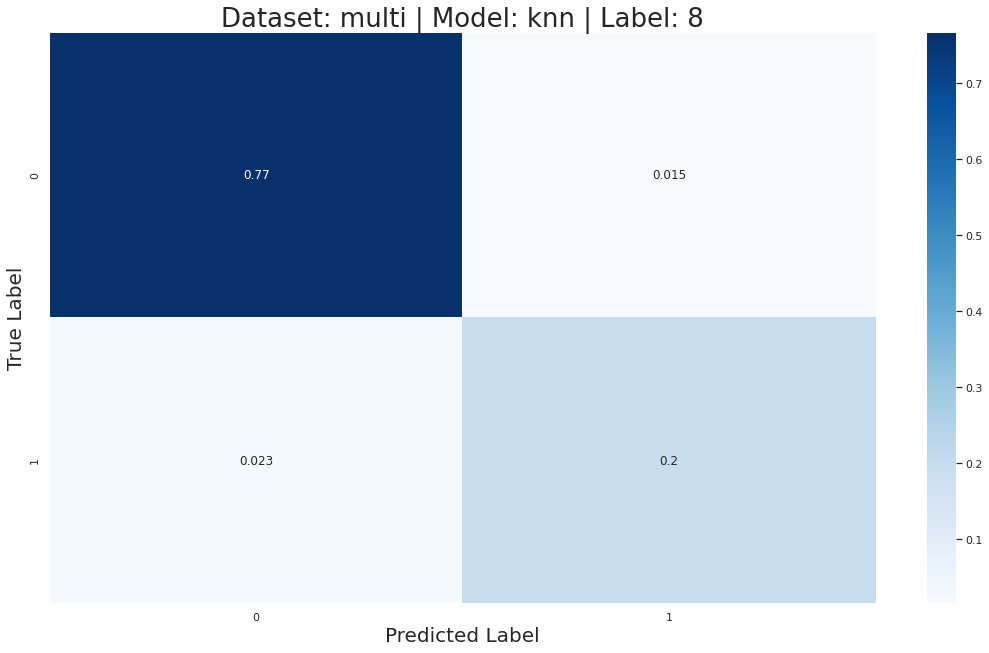

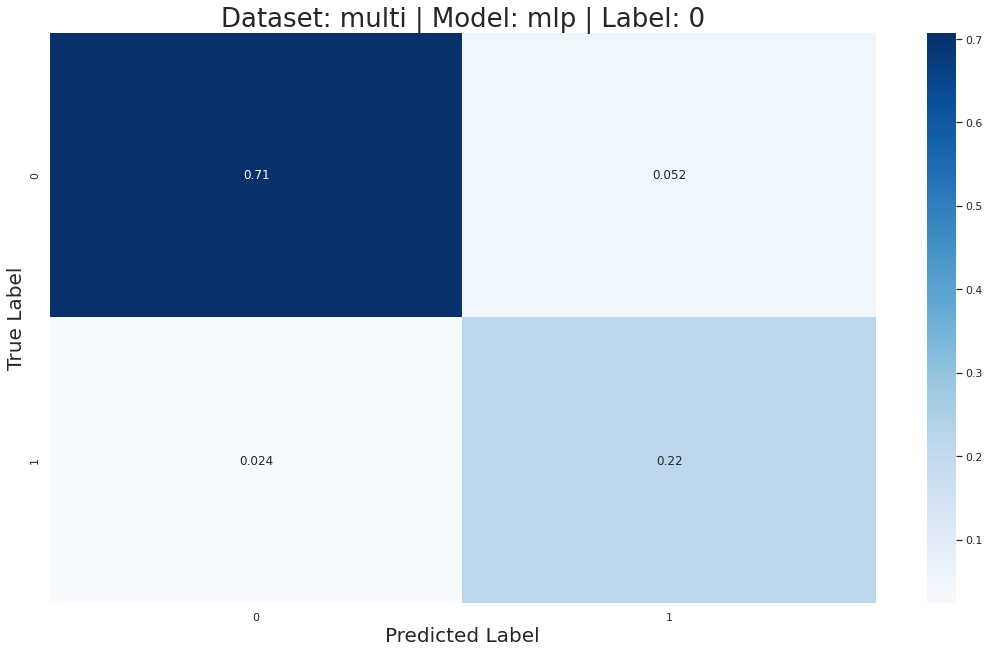

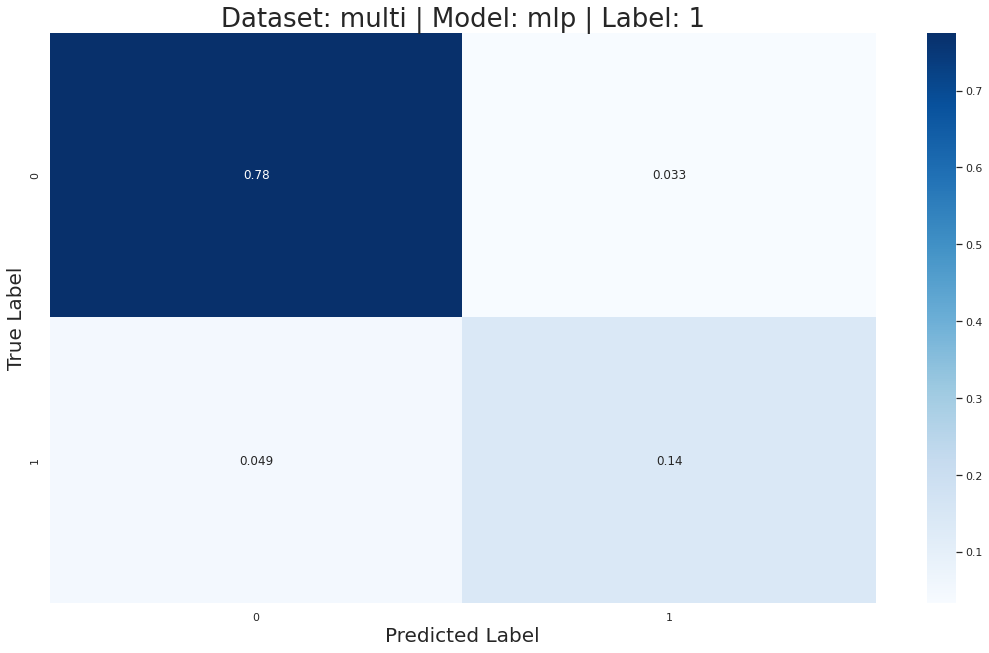

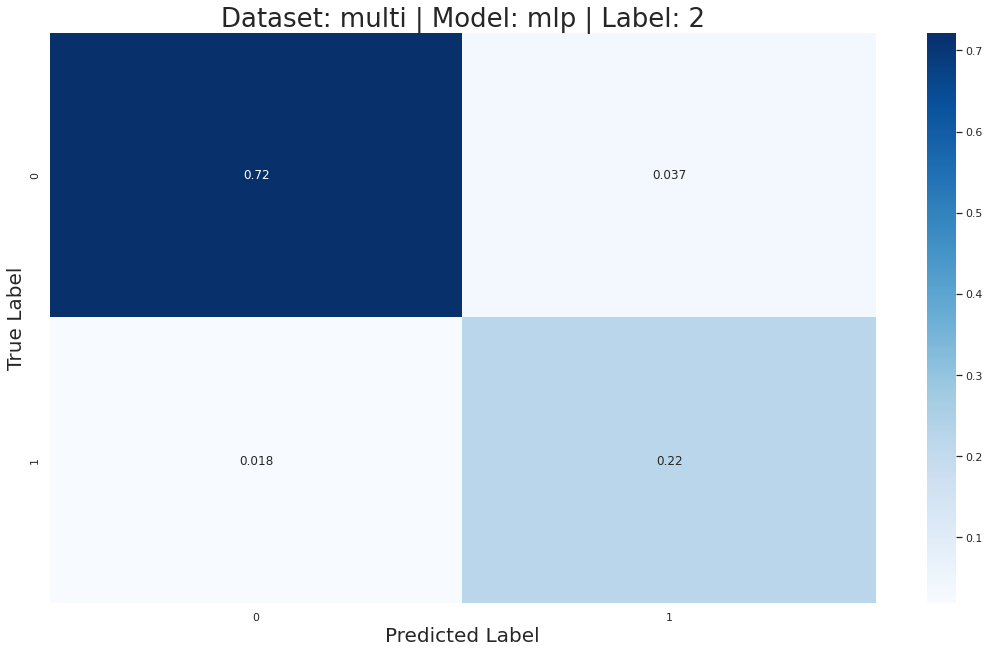

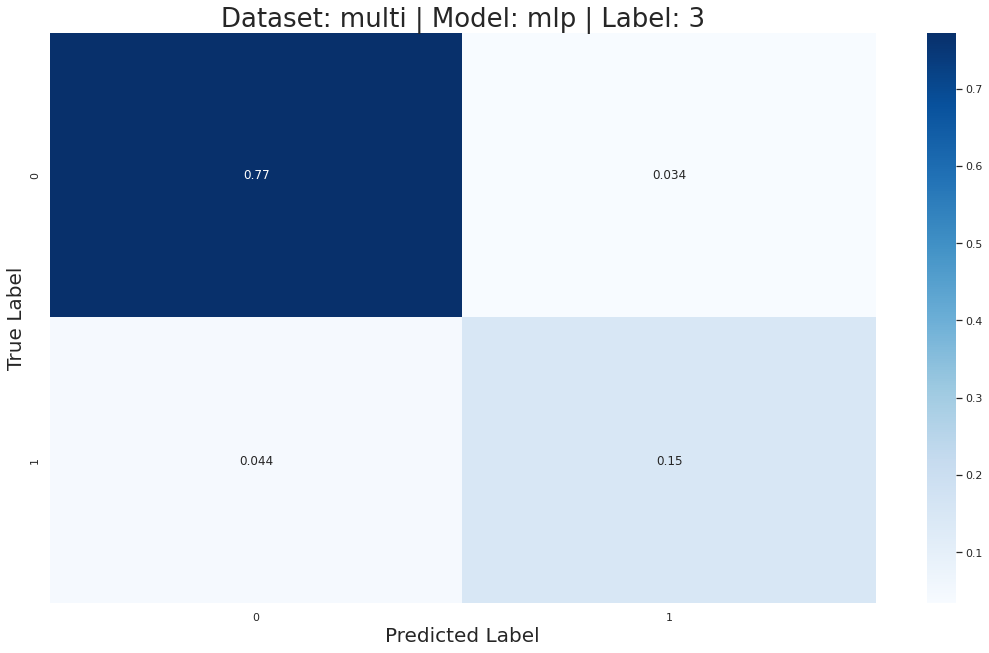

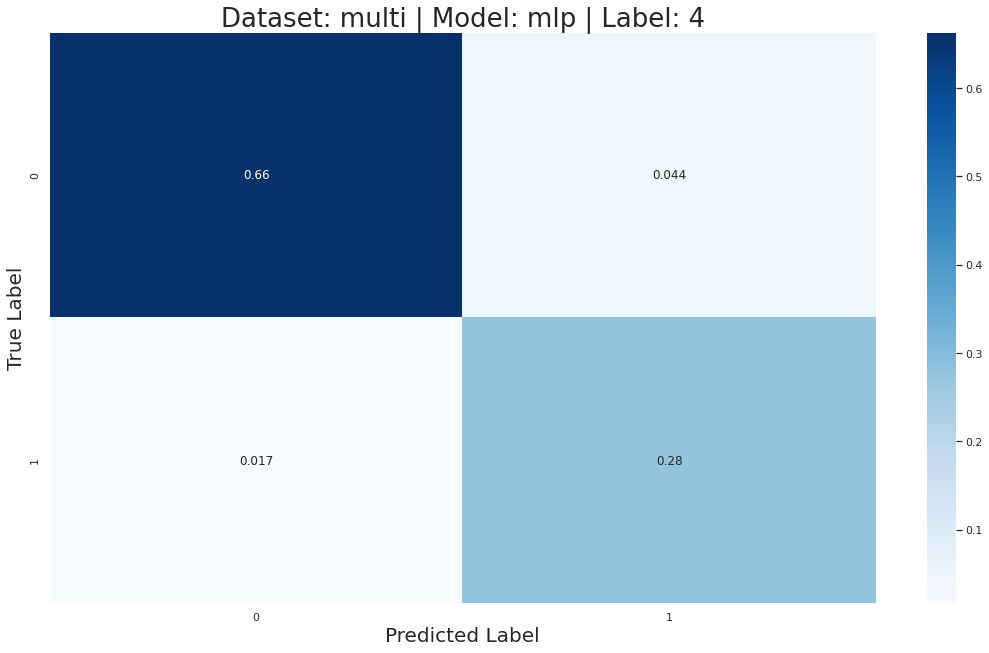

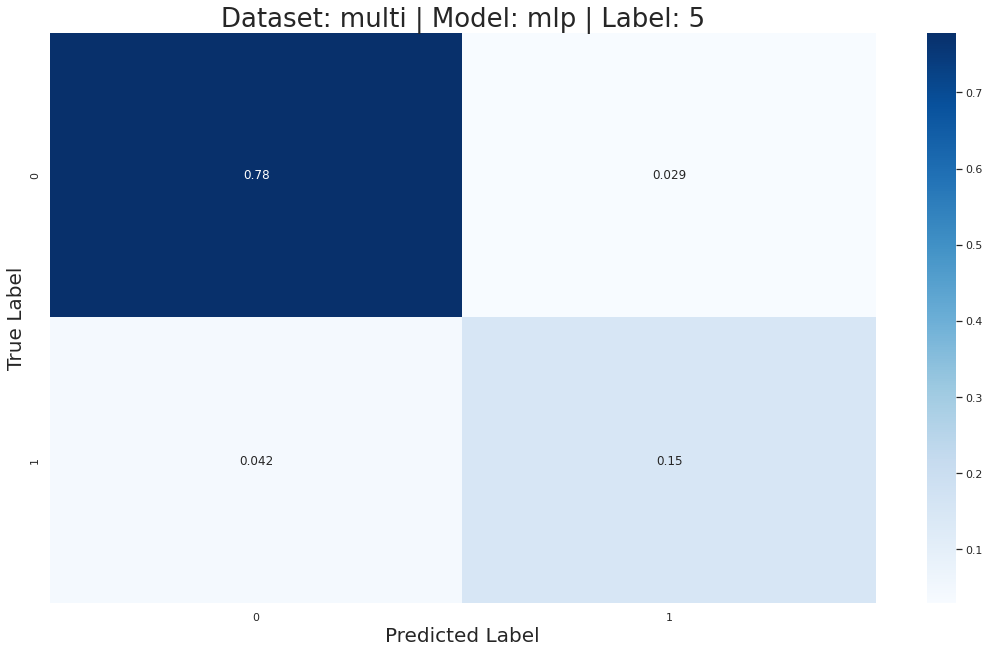

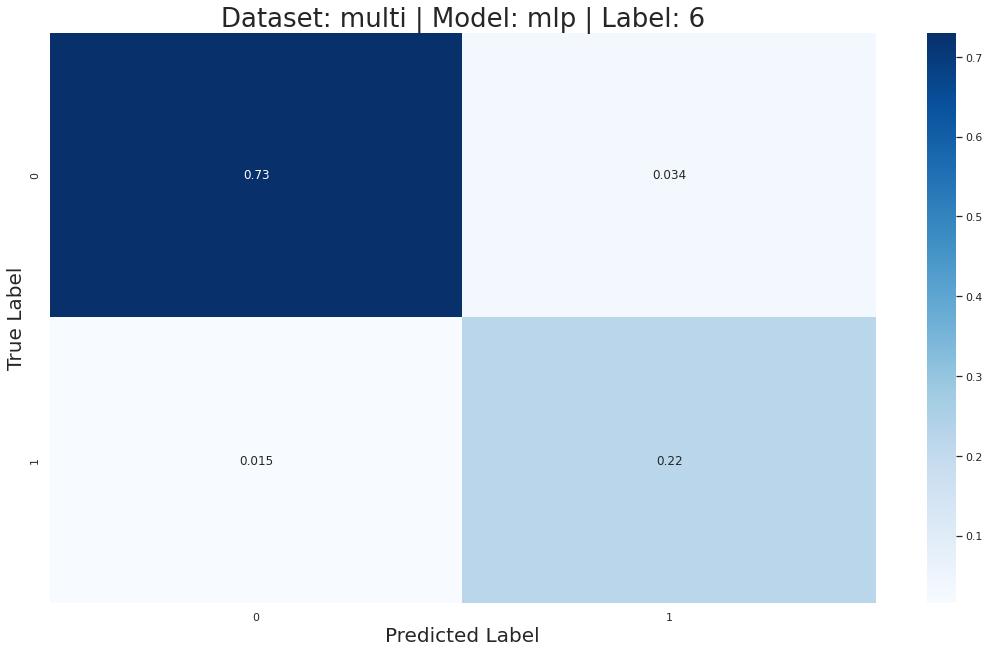

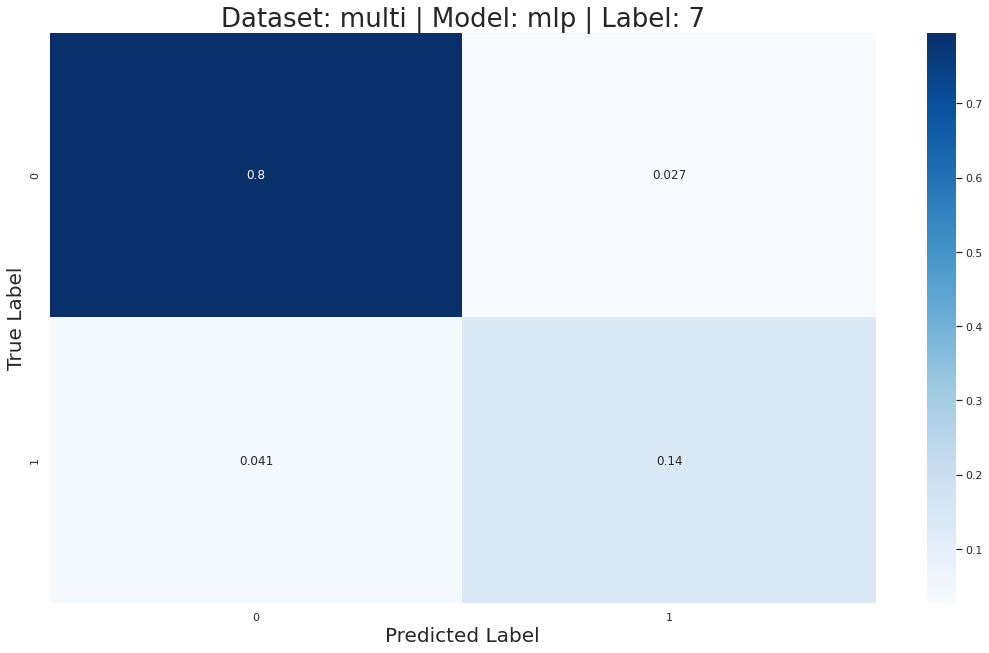

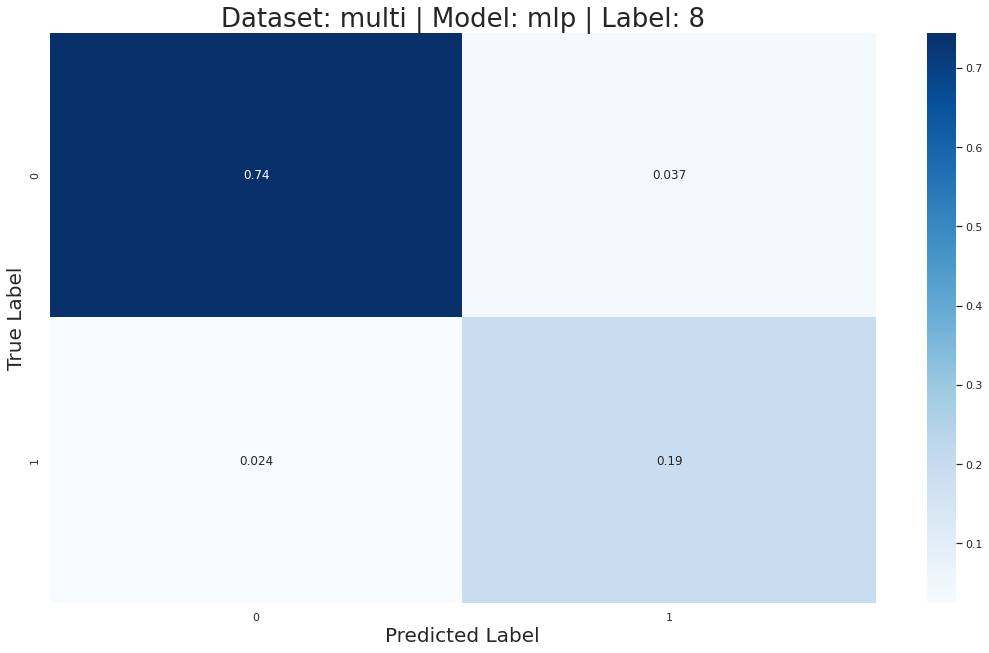

In [23]:
for key, value in predictions.items():
    for model_key, model_preds in value.items():
        if key in ['single', 'final']:
            title = 'Dataset: {} | Model: {}'.format(key, model_key)
            labels = np.unique(data_splits[key]['labels']['test'])
            
            # display labels as -1 and 1 for final dataset
            # because -1 was changed to 0 during preprocessing
            labels = np.array([-1, 1]) if key == 'final' else labels
            
            display_confusion_matrix(data_splits[key]['labels']['test'], 
                                     model_preds, title, 
                                     labels)
        elif key == 'multi':
            n_cols = model_preds.shape[1]
            
            # Loop over each label and display confusion matrix
            for i in range(n_cols):
                title = 'Dataset: {} | Model: {} | Label: {}'.format(key, model_key, i)
                
                display_confusion_matrix(data_splits[key]['labels']['test'][:,i], 
                                         model_preds[:,i], title,
                                         np.unique(data_splits[key]['labels']['test'][:,i]))